In [1]:
# Global imports

import biosteam as bst
import thermosteam as tmo
import biorefineries as bf
from biorefineries import cellulosic
from biosteam import create_conventional_wastewater_treatment_system

# Local imports
from lignin_saf.reactor import *

from ligsaf_tea import ConventionalEthanolTEA
from cellulosic_tea import create_cellulosic_ethanol_tea

In [2]:
# Code just to increase the number of display units for the various components
tmo.Stream.display_units.N = 40       # Increasing number of display units to see all components of streams 
tmo.MultiStream.display_units.N = 40  
bst.Stream.display_units.N = 40       # Increasing number of display units to see all components of streams 
bst.MultiStream.display_units.N = 40  

In [3]:
# bst.nbtutorial() # Light-mode html diagrams and filter warnings

In [4]:
def create_chemicals():


    # copying cellulosic ethanol chemicals 
    chems = cellulosic.create_cellulosic_ethanol_chemicals().copy()

    # Adding pre-existing chemicals
    methanol = tmo.Chemical('Methanol')
    hydrogen = tmo.Chemical('Hydrogen')
    methane = tmo.Chemical('Methane')
    activated_carbon = tmo.Chemical('ActivatedCarbon', search_db=False, default=True, phase='s')

    
    # Custom chemical properties estimated using NIST ThermoDataEngine (TDE) from Aspen Plus V14
    # Only propylguaiacol was native to Aspen, every other component was user defined
    # All six of these user defined components are the same as chosen by Bartling et al Fig S8
    # Constant properties like normal boiling point, critical temp, critical pressure were added
    # Custom models for heat capacity, density as functions of temperatures were NOT included
   
    propylguaiacol = tmo.Chemical(  # S-Lignin Monomer 
        'Propylguaiacol',
        default = True,      # Defaults all other properties 
        search_db=False,     # Since not present in database, do not search
        formula='C10H14O2',  # Chemical formulae
        phase='l',           # phase at rtp
        omega = 0.6411,      # accentric factor
        Tb = 541.7,          # [K]  normal boiling point
        # Tc = 749,            # [K]  critical temperature
        # Pc = 2.9e6,          # [Pa] critical pressure
        Hvap = 7.78e4,       # [J/mol] enthalpy of vaporization at 298 K
        rho = 1056.3,        # [kg/m3] density at rtp

    )
    propylguaiacol.synonyms = ('4-Propylguaiacol',) # Synonyms that can be used to refer to it

    
    propylsyringol = tmo.Chemical(   # G-Lignin Monomer 
        'Propylsyringol',
        default = True,
        search_db=False,
        formula='C11H16O3',
        phase='l',
        omega = 0.87334, 
        Tb = 617.3,      
        #Tc = 819,        
        # Pc = 2565348.3,   
        Hvap = 1.07e5,    
        rho  = 1274.3    
    )
    propylsyringol.synonyms = ('4-Propylsyringol',)

    syringaresinol = tmo.Chemical(  # S-Lignin Dimer 
        'Syringaresinol',
        default = True,
        search_db = False,
        formula = 'C22H26O8',
        phase = 'l',
        omega = 1.4608,
        Tb = 796.7,
        # Tc = 979,
        # Pc = 1.83e6,
        Hvap = 1.99e5,
        rho = 1596.5
    )

    g_dimer = tmo.Chemical(   # Couldn't find a chemical name so going with g_dimer
        'G_Dimer',
        default = True,
        search_db = False,
        MW = 362.42,
        phase = 'l',
        omega = 1.3966,
        Tb = 812.6,
        # Tc = 992,
        # Pc = 1.54e6,
        Hvap = 1.97e5,
        rho = 1497.3
    )

    s_oligomer = tmo.Chemical(
        'S_Oligomer',
        default = True,
        search_db = False,
        MW = 628.67,
        phase = 'l',
        omega = 0.78742,
        Tb = 921.4,
        # Tc = 1128,
        # Pc = 8.27e5
    )  

    g_oligomer = tmo.Chemical(    # Found little to no properties for G_Oligomer
        'G_Oligomer',
        default = True,
        search_db = False,
        MW = 540.65,
        phase = 'l'
    )


    # 4) Extend the base collection
    chems.extend([methanol, hydrogen, methane, activated_carbon, propylguaiacol, propylsyringol,syringaresinol,g_dimer,
                  s_oligomer, g_oligomer])

    chems.compile()  # Compiling all the chemicals to one string
    return chems


chems = create_chemicals()
bst.settings.set_thermo(chems) # Setting thermodynamic property pacakge for the chemicals


In [5]:
bst.settings.CEPCI = 541.7   # CEPCI for 2016, set to same as Bartling paper

In [6]:
# Defining poplar group based off composition given in Bartling et al Table S1

chems.define_group(
    name='Poplar',
    IDs=['Glucan',      # Changed cellulose to glucan name here # Cellulase break this down to glucose
         'Xylan',       # Hemicellulose
         'Arabinan',    # Hemicellulose
         'Mannan',      # Hemicellulose
         'Galactan',    # Hemicellulose
         'Sucrose',   
         'Lignin',
         'Acetate',
         'Extract',     # Non structural component of biomass that dissolves in solvent/water 
         'Ash'],
    composition=[0.464,      # Dry wt composition, feed also has 20 wt% moisture content
                 0.134,
                 0.002,
                 0.037,
                 0.014,
                 0.001,
                 0.285,
                 0.035,
                 0.016,
                 0.012],
    wt=True
)


In [7]:
# Process conditions from Bartling et al 2021 unless specified otherwise


# Feed
biomass_flow = 2000                   # [dry metric tons per day], consistent with other TEA models 
biomass_moisture  = 0.2               # [%] 20% moisture

# RCF
rcf_temp = 200 + 273.15            # [K]
rcf_pressure = 60 * 1e5            # [bar]
solvolysis_tau = 2                 # [hr] residence time
hydrogenolysis_tau = 1             # [hr] residence time
meoh_h2o = 9                       # [ratio] Solvent : Water ratio
delignification = 0.7              # [%] 70% biomass delignified
methanol_decomp = 0.005            # [%] methanol decomposition rate (loss of solvent due to conversion into carbonaceous gases)

methanol_to_ch4 = 0.128/100        # [wt%] methanol lost as CH4. From https://pubs.rsc.org/en/content/articlelanding/2015/cc/c5cc04025f Table 1 where 0.08 mol% of methanol lost as CH4 for Ru/C catalyst
                                   # reactor was batch and hydrogen was fed at 3 MPa within the reactor, also biomass was birchwood so this might be different in my case

methanol_to_co = 0.364/100         # [wt%] methanol lost as CH4. From https://pubs.rsc.org/en/content/articlelanding/2015/cc/c5cc04025f Table 1 where 0.13 mol% of methanol lost as CH4 for Ru/C catalyst
                                   # reactor was batch and hydrogen was fed at 3 MPa within the reactor, also biomass was birchwood, so this might be different in my case

h2_consumption = 0.01241           # h2 consumption per kg dry biomass feed. Roughly 0.02958 kg H2 consumed per kg RCF oil, I just back calculated it in terms of dry biomass feed so I can use it as an input parameter

cellulose_retention = 0.9          # [%] 90% cellulose retained in biomass pulp after RCF
xylose_retention = 0.93            # [%] 93% xylose retained in biomass pulp after RCF
extractives_retention = 0          # [%] extractives retention in biomass from 10.1039/d1gc01591e Table S1 (no extractives in post-solvolysis poplar)
                                   # Also validated from SI Table S17 of Bartling et al where extractives total amount (kg) in RCF oil is similar to what is in the poplar feed 
acetate_retention = 0              # [%] acetate retention in biomass from 10.1039/d1gc01591e Table S1 (no acetate in post-solvolysis poplar)
arabinan_retention = 0.4           # [%] Bartling et al
galactan_retention = 0.5           # [%] Bartling et al
mannan_retention = 0.5             # [%] Bartling et al
cat_replace = 1                    # [/yr] catalyst replacement rate
methanol_to_biomass = 9            # [L/kg] from https://doi.org/10.1016/j.copbio.2018.12.005
                                   # Surprisingly, Bartling et al assumes a 9L/kg for a flow through
                                   # configuration which is very less.
h2_biomass_ratio = 0.053958086     # Ratio of mass flow of h2 by the mass flow of dry biomass feed from Bartling et al, SI stream tables (Table S2)
                                   # Main text mentioned 10 L/min/dry kg biomass (STP) but i don't know what the dry kg biomass is normalized to (/day, /hr ?)

catalyst_loading = 0.1             # 1:10 catalyst: dry biomass feed by wt 
catalyst_cost = 37.5               # USD/kg from Bartling et al.

# RCF oil composition
lignin_monomers = 0.5
lignin_dimers = 0.25
lignin_oligomers = 0.25 





In [8]:
meoh_recycle = bst.MultiStream('Meoh_recycle', phases = ('s','l','g'))

In [9]:
# Inlet poplar stream, should ideally be a solid-liquid stream but the cellulosic ethanol model 
# in BioSTEam takes in feedstocks as liquid composiiton only and hence I define it solely
# as a liquid. Nativgfely compopunds like lignin are also described solely as liquid only in BioSTEAM
poplar_in = bst.Stream('Poplar_In',
                Poplar =  biomass_flow*1e3, Water = biomass_moisture*biomass_flow*1e3,
                 phase = 'l', units='kg/d')



In [10]:
meoh_in = bst.Stream('Meoh_in',
                    Methanol =  (methanol_to_biomass*biomass_flow*1e3*0.9),
                    Water =  methanol_to_biomass*biomass_flow*1e3*(1/meoh_h2o)*0.9,
                     phase = 'l',   
                     units = 'L/d')

# Set as a MultiStream to make it easier later on as this stream will also contain carbohydrate
# derivatives (solids) following solvolysis and hydrogen (gas) following hydrogenolysis

# both flows multipled by 0.9 to make the overall meoh_in to biomass liter to kg ratio as 90 which is a requirement

In [11]:
#fresh_meoh_pump = bst.units.Pump('PUMP100', ins = meoh_in, P = rcf_pressure)
#fresh_meoh_heater = bst.units.HXutility('HX100', ins = fresh_meoh_pump-0, T = rcf_temp, rigorous = True)
#fresh_meoh_pump.simulate()
#fresh_meoh_heater.simulate()

#fresh_meoh_heater.outs[0].phase = 'l'

In [12]:
#meoh_recycle_pump = bst.units.Pump('PUMP00', ins = meoh_recycle, P = rcf_pressure)
#meoh_recycle_heater = bst.units.HXutility('HX00', ins = meoh_recycle_pump-0, T = rcf_temp, rigorous = True)
#meoh_recycle_pump.simulate()
#meoh_recycle_heater.simulate()
#meoh_recycle_heater.outs[0].phases = ('l','g') # These phases must be available for solvolysis and hydrogenolysis reactors downstream

In [13]:
meoh_h2o_mix = bst.units.Mixer('MIX100', ins = (meoh_in, meoh_recycle), rigorous = True)
@meoh_h2o_mix.add_specification(run = True)
def meoh_water_flow():
    fresh_solvent = meoh_h2o_mix.ins[0]
    recycle_solvent = meoh_h2o_mix.ins[1]

    meoh_flow_mol  = (((methanol_to_biomass*biomass_flow*1e3*0.9)/1000)/24) * chems['Methanol'].rho(phase = 'l', T = rcf_temp, P = rcf_pressure)  * (1/chems['Methanol'].MW)  # Converting flow from L/day to kmol/hr
    fresh_solvent.imol['Methanol'] = meoh_flow_mol - recycle_solvent.imol['Methanol']

    water_flow_mol = ((methanol_to_biomass*biomass_flow*1e3*(1/meoh_h2o)*0.9)/1000/24) * chems['Water'].rho(phase = 'l', T = rcf_temp, P = rcf_pressure)  * (1/chems['Water'].MW) 
    fresh_solvent.imol['Water'] = water_flow_mol - recycle_solvent.imol['Water']
meoh_h2o_mix.simulate()
meoh_h2o_mix.outs[0].phases = ('s', 'l','g')  # These phases must be available for solvolysis and hydrogenolysis reactors downstream

In [14]:
'''
# Checks to ensure the correct methanol to biomass and methanol to water ratio is used
meoh_biomass_check = round((meoh_h2o_mix.outs[0].F_vol*1000)/(2e6/24),0)
methanol_water_check = round(meoh_h2o_mix.outs[0].ivol['Methanol']/meoh_h2o_mix.outs[0].ivol['Water'],0)

if meoh_biomass_check == methanol_to_biomass:
    print('Correct methanol to biomass ratio')

else:
    raise ValueError(f'Methanol to biomass ratio is {meoh_biomass_check} L/kg dry biomass \n It must be {methanol_to_biomass} L/kg dry biomass as specified')

if methanol_water_check == meoh_h2o:
    print('Correct methanol water ratio')

else:
    raise ValueError(f'Methanol water ratio is {methanol_water_check} \n It must be {meoh_h2o}')
'''

"\n# Checks to ensure the correct methanol to biomass and methanol to water ratio is used\nmeoh_biomass_check = round((meoh_h2o_mix.outs[0].F_vol*1000)/(2e6/24),0)\nmethanol_water_check = round(meoh_h2o_mix.outs[0].ivol['Methanol']/meoh_h2o_mix.outs[0].ivol['Water'],0)\n\nif meoh_biomass_check == methanol_to_biomass:\n    print('Correct methanol to biomass ratio')\n\nelse:\n    raise ValueError(f'Methanol to biomass ratio is {meoh_biomass_check} L/kg dry biomass \n It must be {methanol_to_biomass} L/kg dry biomass as specified')\n\nif methanol_water_check == meoh_h2o:\n    print('Correct methanol water ratio')\n\nelse:\n    raise ValueError(f'Methanol water ratio is {methanol_water_check} \n It must be {meoh_h2o}')\n"

In [15]:
meoh_pump = bst.units.Pump('PUMP101', ins = meoh_h2o_mix-0, P = rcf_pressure)
meoh_heater = bst.units.HXutility('HX102', ins = meoh_pump-0, T = rcf_temp, rigorous = True)
meoh_pump.simulate()
meoh_heater.simulate()
meoh_heater.outs[0].phases = ('l','g')  # These phases must be available for solvolysis and hydrogenolysis reactors downstream

In [16]:

# Checks to ensure the correct methanol to biomass and methanol to water ratio is used
meoh_biomass_ratio_check = round((meoh_heater.outs[0].F_vol*1000)/(2e6/24),0)
methanol_water_ratio_check = round(meoh_heater.outs[0].ivol['Methanol']/meoh_heater.outs[0].ivol['Water'],0)

if meoh_biomass_ratio_check == methanol_to_biomass:
    print('Correct methanol to biomass ratio')

else:
    raise ValueError(f'Methanol to biomass ratio is {meoh_biomass_ratio_check} L/kg dry biomass \n It must be {methanol_to_biomass} L/kg dry biomass as specified')

if methanol_water_ratio_check == meoh_h2o:
    print('Correct methanol water ratio')

else:
    raise ValueError(f'Methanol water ratio is {methanol_water_ratio_check} \n It must be {meoh_h2o}')


Correct methanol to biomass ratio
Correct methanol water ratio


In [17]:

# Solvolysis reaction to solubilize lignin from cell wall
solvolysis_rxn = bst.Reaction('Lignin -> SolubleLignin', reactant = 'Lignin', X = 0.7, basis = 'wt', correct_atomic_balance = False) 
# correct atomic balance set to False because we are working with pseudocomponents


# Methanol decomposition to light gases
methanol_decomposition_rxn = bst.ParallelReaction([
    bst.Reaction('Methanol,l -> Methane,g', reactant = 'Methanol', phases = 'lg', X = methanol_to_ch4 ,basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('Methanol,l -> CO,g', reactant = 'Methanol', phases = 'lg', X= methanol_to_co, basis = 'wt', correct_atomic_balance=False)
])


In [18]:
meoh_initial_rho = chems['Methanol'].rho(phase = 'l', T = 18, P = 101325)
meoh_rcf_in_rho = chems['Methanol'].rho(phase = 'l', T = 200+273.15, P = 6e6)
print(f'Methanol density at initial conditions is {round(meoh_initial_rho,2)} kg/m3')
print(f'Methanol density at initial conditions is {round(meoh_rcf_in_rho,2)} kg/m3')
print(f'Bartling et al for 9 L/kg ratio refer to preheated meoh hence heating methanol \nbefore imposing specification of 9 L/kg')

Methanol density at initial conditions is 904.61 kg/m3
Methanol density at initial conditions is 580.17 kg/m3
Bartling et al for 9 L/kg ratio refer to preheated meoh hence heating methanol 
before imposing specification of 9 L/kg


In [19]:
"""
References
-----------
    [1] Bartling, Andrew W., et al. 
    "Techno-economic analysis and life cycle assessment of a biorefinery utilizing
    reductive catalytic fractionation." Energy & Environmental Science 14.8 (2021): 4147-4168.

    [2] Anderson, Eric M., et al. 
    "Flowthrough reductive catalytic fractionation of biomass." Joule 1.3 (2017): 613-622.

    [3] Froment, Gilbert F., Kenneth B. Bischoff, and Juray De Wilde. 
    Chemical reactor analysis and design. Vol. 2. New York: Wiley, 1990.
-----------
"""

import biosteam as bst, numpy as np
from math import ceil

from typing import Optional
from biosteam.units.design_tools import (
    PressureVessel, 
)
 


__all__ = (
    'SolvolysisReactor', 'RCF1'
    )

class SolvolysisReactor(bst.Unit, bst.units.design_tools.PressureVessel):

    """
    Plug flow reactor for solvolysis reaction, where a solvent is used to solubilize lignin present
    in plant cell wall

    In reality, lignin will also be partially depolymerized, but this phenomena is not captured in 
    current design but may be included in a future implementation
    Design based off [1],[2]. Pressure drop calculations from [3]

    By default,  current design supports multiples of 3 identical biomass beds, with 2x operational beds at any given time, 
    offset by 1 hour each. With a 3 hr reaction time + 1 hr turnaround, this gives near continuous throughput
    Example... t = 0 - 1 hr : bed 1, bed 2 online, bed 3 cleaning, 
                t = 1 - 2 hr, bed 2, bed 3 online, bed 1 cleaning
    Since at any given time, the complete throughput is mantained by 2x reactors, the total volumetric flow rate 
    of solvent is constant

    The maximum volume of an individual reactor was fixed at 600 m3, similar to what was suggested in Bartling et al
    For the solvent flow rate of 9 L/kg dry biomass, this corresponds to  
    
    Assumed: Extraction efficiency constant along the reaction residence time
    No energy released on extraction of lignin. Although this assumption might be revised in the future
    
    
    
    
    
    
    
    """



    _F_BM_default = {'Horizontal pressure vessel': 3.05,
                     'Vertical pressure vessel': 4.16,
                     'Platform and ladders': 1.}                   

    auxiliary_unit_names = (
        'pump_1', 'heat_exchanger_1'
    )

    _N_ins = 2
    _N_outs = 2
    
    _units = {**PressureVessel._units,
              'Pressure drop': 'bar',
              'Batch time': 'hr',
              'Turnaround time': 'hr',
              'Residence time': 'hr',
              'Total beds': "",
              'Beds in service': "",
              'Total volume': 'm3',
              'Reactor volume': 'm3'}
    


    # Default operating temperature [K]
    T_default: float = 463.15                   # 190 C from  https://doi.org/10.1016/j.joule.2017.10.004

    #: Default operating pressure [Pa]
    P_default:  float = 6e6                     # 6 MPa from https://doi.org/10.1016/j.joule.2017.10.004
    
    #: Default residence time [hr]
    tau_default: float = 2                      # Total 3 hr RCF reaction time divided into 2:1 since solvolysis is more kinetically limiting according to https://pubs.acs.org/doi/full/10.1021/acssuschemeng.8b01256

    #: Default cleaning and unloading time (hr).
    tau_0_default: float  = 1                    # from https://doi.org/10.1039/D1EE01642C
    
    # Default superficial velocity of solvent (m/s)
    superficial_velocity_default: float = 1      # Just assumed 

    # Default methanol decomposition (%)
    methanol_decomposition_default: float = 0.005 # From https://doi.org/10.1039/D1EE01642C

    # Default poplar bed void fraction (epsilon)
    void_frac_default: float = 0.5                # Just assumed here, can be fine tuned once data is known. Assyned because this value gives a low value for pressure drop


    # Default working volume fraction 
    working_vol_default: float = 0.8              # Just assumed based off engineering judgement
 
    # Default poplar diameter [m]
    poplar_diameter_default: float = 0.004        # https://doi.org/10.1039/D1EE01642C mentions < 5mm, Here 4 mm is considered
    
    # Default maximum vessel volume [m3]
    V_max_default: float = 600                    # Bartling paper considered reactor volume as 600 m3



    def _init(
            self,
            T: Optional[float] = None, 
            P: Optional[float] = None,
            tau: Optional[float] = None,
            vessel_material: Optional[str] = None,
            vessel_type: Optional[str] = None,
            tau_0: Optional[float] = None,  
            superficial_velocity: Optional[float] = None,
            methanol_decomposition: Optional[float] = None,
            void_frac: Optional[float] = None,
            working_vol: Optional[float] = None,
            poplar_diameter: Optional[float] = None,
            V_max: Optional[float] = None,
            *,
            reaction_1,
            reaction_2
            ):
        
        
        self.T = self.T_default if T is None else T
        self.P = self.P_default if P is None else P
        self.tau = self.tau_default if tau is None else tau
        self.vessel_material = 'Stainless steel 316' if vessel_material is None else vessel_material
        self.vessel_type = 'Vertical' if vessel_type is None else vessel_type
        self.tau_0 = self.tau_0_default if tau_0 is None else tau_0
        self.superficial_velocity = self.superficial_velocity_default if superficial_velocity is None else superficial_velocity
        self.methanol_decomposition = self.methanol_decomposition_default if methanol_decomposition is None else methanol_decomposition
        self.void_frac = self.void_frac_default if void_frac is None else void_frac
        self.working_vol = self.working_vol_default if working_vol is None else working_vol
        self.poplar_diameter = self.poplar_diameter_default if poplar_diameter is None else poplar_diameter
        self.V_max = self.V_max_default if V_max is None else V_max
        self.reaction_1 = reaction_1
        self.reaction_2 = reaction_2
        pump_1 = self.auxiliary('pump_1', bst.Pump, ins = self.ins[1])
        # heat_exchanger_1 = self.auxiliary('heat_exchanger_1', bst.HXutility, pump_1.outs[0])







    def _size_bed(self):
        
        #### Reactor volume sizing ########

        cycle_time = self.tau + self.tau_0                         # [hr] Total time for a cycle of operation (includes reaction + cleaning-loading-unloading)
        working_vol = self.working_vol                             # Working volume fraction for a reactor to allow suficient mass transfer by allowing enough contact time 
        solvent = self.ins[1]                                      # Preheated solvent inlet

        V_theoretical = solvent.F_vol * self.tau                   # [m3] Theoretical volume required for solvolysis 
        V_actual = V_theoretical/(working_vol * self.void_frac)    # [m3] Actual volume required based off void fraction in poplar bed, and fraction working volume over total reactor length
        N_working = ceil(V_actual/self.V_max)                      # Number of working reactors, rounded off the to the next number
        N_offline = ceil(N_working*(self.tau_0/cycle_time))        # Number of offline beds, calculated based off cleaning time and the total cycle time, rounded off to the next number
        N_total = N_working + N_offline
        V_total = N_total * self.V_max

        

        ##### Reactor diameter and length ########

        u  = self.superficial_velocity                      # [m/s]
        Q_per_reactor_m3 = solvent.F_vol/N_working          # [m3/hr] Volumetric flow rate processed by any reactor
        self.area = A  = Q_per_reactor_m3/(u*3600)          # [m3] Cross sectional area for each reactor
        self.diameter = diameter = 2 * (A/np.pi) ** 0.5     # [m] Diameter of each reactor
        self.length = length = self.V_max/A                 # [m] Length of each reactor

        
        return length, diameter, N_total, N_working, V_total

        
    def _run(self):
        biomass, solvent = self.ins
        used_biomass, used_solvent = self.outs

        used_solvent.copy_like(solvent) 
        used_biomass.copy_like(biomass) 

        used_solvent.P = self.P                                             # Outlet pressure is set to reactor pressure. Inlet pressure will be greater to account for pressure drop
        used_solvent.T = self.T                                             # Since isothermal operation
        

        self.reaction_1(used_biomass) 
        self.reaction_2(used_solvent)
        

        solubilized_lignin = used_biomass.imass['SolubleLignin'] 
        used_solvent.imass['l', 'SolubleLignin'] += solubilized_lignin      # Soluble lignin dissolves in solvent effluent stream 
        used_biomass.imass['SolubleLignin'] = 0                             # No soluble lignin remaining in biomass (assuming 100% extraction efficiency)



        extractives = used_biomass.imass['Extract']                         # From Table S1 https://www.rsc.org/suppdata/d1/gc/d1gc01591e/d1gc01591e1.pdf,
                                                                            # it follows that the extractives component of poplar is 'extracted' in the solvent stream
        used_solvent.imass['l','Extract'] = (1-extractives_retention)*extractives
        used_biomass.imass['Extract'] = (extractives_retention)*extractives

        acetate = used_biomass.imass['Acetate']
        used_solvent.imass['l', 'Acetate'] =  acetate *(1-acetate_retention) # Assuming acetate dissolves as acetic acid with methanol,
                                                                             # BioSTEAM Chemicals assumes same properties for acetic acid and acetate, otherwise is acetate was a pseudocomponent, it might have still stayed in solid phase
        used_biomass.imass['Acetate'] = acetate*acetate_retention


        cellulose_mass = used_biomass.imass['Glucan']
        used_solvent.imass['l', 'Glucan'] = cellulose_mass*(1-cellulose_retention) # Dissolved cellulose assumed to be in liquid phase as solution with solvent
        used_biomass.imass['Glucan'] =  cellulose_mass*cellulose_retention
                                                               

        xylose_mass = used_biomass.imass['Xylan']
        used_solvent.imass['l', 'Xylan'] = xylose_mass * (1-xylose_retention) # Dissolved xylose assumed to be  liquid phase as solution with solvent
        used_biomass.imass['Xylan'] = xylose_mass * xylose_retention
        

        arabinan_mass = used_biomass.imass['Arabinan']
        used_solvent.imass['l', 'Arabinan'] = arabinan_mass * (1-arabinan_retention) 
        used_biomass.imass['Arabinan'] = arabinan_mass * arabinan_retention
        
        mannan_mass = used_biomass.imass['Mannan']
        used_solvent.imass['l', 'Mannan'] = mannan_mass * (1-mannan_retention) 
        used_biomass.imass['Mannan'] = mannan_mass * mannan_retention

        galactan_mass = used_biomass.imass['Galactan']
        used_solvent.imass['l', 'Galactan'] = galactan_mass * (1-galactan_retention) 
        used_biomass.imass['Galactan'] = galactan_mass * galactan_retention        
        

        # The temperature and pressure of the carbohydrate pulp is not changed here, I'm assuming I obtain the pulp at ambient conditons 
        # once RCF reaction is complete for downstream processing
        



    def _calculate_pressure_drop(self, bed_length):

        D = self.poplar_diameter                                # [m] poplar particle diameter
        rho = self.ins[1].rho                                   # [kg/m3] 
        mu = self.ins[1].get_property('mu', 'kg/m/s')           # [Pa s] methanol water viscosity 
        epsilon = self.void_frac                                # Void fraction 
        u = self.superficial_velocity                           # [m/s] superficial velocity  

        
        
        Re = (D*rho*u)/mu
        if Re/(1-epsilon) < 500: # Erun equation
            f = ((1-epsilon)/(epsilon**3))*(1.75+(150*(1-epsilon)/Re))
            dP = (f * ((rho*(u**2))/D)* bed_length)*1e-5                # [bar] 1e-5 converts Pa to bar
        elif 1000 < Re/(1-epsilon) < 5000: # Handley and Heggs
            f = ((1-epsilon)/(epsilon**3))*(1.24+(368*(1-epsilon)/Re))
            dP = (f * ((rho*(u**2))/D)* bed_length)*1e-5
        else: # Hicks equation which fits in Wentz and Thodos results for very high Re
            f = 6.8*(((1-epsilon)**1.2)/epsilon**3)*Re**-0.2
            dP = (f * ((rho*(u**2))/D) * bed_length)*1e-5
        return dP

        

    def _design(self):
        length, diameter, N_reactors, N_operating, total_volume = self._size_bed()   # Calling size bed function to determine diameter and length 
        


        
        
        
        cycle_time = self.tau + self.tau_0

        self.set_design_result('Diameter', 'ft', diameter)  
        self.set_design_result('Length', 'ft', length)
        self.set_design_result('Reactor volume', 'm3', self.V_max_default)
        self.set_design_result('Total volume', 'm3', total_volume)
        self.set_design_result('Total beds', '', N_reactors)
        self.set_design_result('Beds in service', '', N_operating)
        self.set_design_result('Residence time', 'hr', self.tau)
        self.set_design_result('Turnaround time', 'hr', self.tau_0)
        self.set_design_result('Batch time', 'hr', cycle_time)

        
        
        # Calculates weight based off pressure, diameter and length
        # Adds vcessel type wall thickness, vessel weight, diameter and length to dictionary
        # But diameter and length are already there because of set_design_result above
        
        self.design_results.update(
            self._vertical_vessel_design(    
                self.P*(1/6894.76),
                self.design_results['Diameter']*3.28084,
                self.design_results['Length']*3.28084
            )
        )
        
                            

        pressure_drop = self._calculate_pressure_drop(length)                  
        
        self.set_design_result('Pressure drop', 'bar', pressure_drop)
        self.pump_1.P = (self.P - self.ins[1].P) + (pressure_drop*1e5)
        self.pump_1.simulate()





    def _cost(self):
        design = self.design_results # Calling the dictionary used to store design results in design method above 

        baseline_purchase_costs = self.baseline_purchase_costs # Dictionary for storing baseline costs

        weight = design['Weight']  # weight parameter stores the value from the 'Weight' key in the design dictionnary
        
        N_reactors = design['Total beds']
        # Calculates the baseline purchase cost based off diameter length and weight
        baseline_purchase_costs.update( 
            self._vessel_purchase_cost(weight, design['Diameter'], design['Length'])
        )

        self.parallel['self'] = N_reactors # Used to create multiple of the same beds
        self.parallel['pump_1'] = 1 # Just one pump needed, valves will redirect to whichever bed is online


        
       
        """
        ---------
          
        Parameters that can be further fine-tuned based on industry/national lab data
        - Void fraction of poplar bed: Herein assumed 0.5, this is subject to change
        - Working volue fraction: Herein assumed 80%, but can change depending on how well mass transfer occurs in real reactors
        - V_max: Maximum volume of a single reactor, herein assumed as 600 m3 based on Bartling et al 2021 paper, but subject to change
        - residence time: Herein 2 hrs, but could change based on which regime is more limiting. 


        ----------

        """

    

        

        


In [20]:
# from biosteam.units.decorators import cost

In [21]:
solvolysis_reactor = SolvolysisReactor('RCF103-S', ins = (poplar_in, meoh_heater-0), outs = ('Carbohydrate_Pulp', 'Solvolysis_Liquor'),
                                    T = rcf_temp,
                                    P = rcf_pressure,
                                    tau = solvolysis_tau, 
                                    # N_beds = 14,
                                    void_frac= 0.5,
                                    superficial_velocity = 0.001, 
                                    reaction_1 = solvolysis_rxn,
                                    reaction_2 = methanol_decomposition_rxn)                                   
solvolysis_reactor.simulate()

# Yes, some of the bounds exceed the limits, but its primarily due to high solvent loadings in 
# the solvolysis reactor

C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\1344518917.py:303: CostWarning: <SolvolysisReactor: RCF103-S> Vertical vessel weight (2.162e+06 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\1344518917.py:303: CostWarning: <SolvolysisReactor: RCF103-S> Vertical vessel length (66.14 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(


In [22]:
solvolysis_reactor.results(())

RCF103-S
Electricity         Power                               28.2
                    Cost                                 2.2
Design              Diameter                            20.2
                    Length                              66.1
                    Reactor volume                       600
                    Total volume                        6000
                    Total beds                            10
                    Beds in service                        7
                    Residence time                         2
                    Turnaround time                        1
                    Batch time                             3
                    Vessel type                     Vertical
                    Weight                          2.16e+06
                    Wall thickness                      9.48
                    Pressure drop                   0.000585
Purchase cost       Vertical pressure vessel (x10)  4.81e+07
                    Platform and ladders (x10)         7e+05
                    Pump 1 - Pump (x10)              1.9e+04
                    Pump 1 - Motor (x10)            1.57e+03
Total purchase cost                                 4.88e+07
Utility cost                                             2.2

In [23]:
## Independent pressure drop calculator for verifying purposes


bed_length = 2.5

def pressure_drop_function(D, rho, mu, epsilon, u, bed_length):
    Re = (D*rho*u)/mu
    if Re/(1-epsilon) < 500: # Erun equation
        f = ((1-epsilon)/(epsilon**3))*(1.75+(150*(1-epsilon)/Re))
        dP = (f * ((rho*(u**2))/D)* bed_length)*1e-5
    elif 1000 < Re/(1-epsilon) < 5000: # Handley and Heggs
        f = ((1-epsilon)/(epsilon**3))*(1.24+(368*(1-epsilon)/Re))
        dP = (f * ((rho*(u**2))/D)* bed_length)*1e-5
    else: # Hicks equation which fits in Wentz and Thodos results for very high Re
        f = 6.8*(((1-epsilon)**1.2)/epsilon**3)*Re**-0.2
        dP = (f * ((rho*(u**2))/D) * bed_length)*1e-5
    return dP
    

#P = pressure_drop_function(D = 0.0037, rho = 0.9487, mu = 3.1e-5, epsilon = 0.38, u = 1.37, bed_length = 2.5)
#print(f'Pressure drop for example is {round(P,3)} bar') 

# This check is from the textbook Chemical Reactor Analysis and Design Example 11.5.1.A just to show the algorithsm working

P2 = pressure_drop_function(D = 0.004, rho = meoh_heater.outs[0].rho, mu = meoh_heater.outs[0].mu, epsilon = 0.5, u = 0.001, bed_length = 20.41)
print(f'Pressure drop for solvolysis is {round(P2,7)} bar')





Pressure drop for solvolysis is 0.0005918 bar


In [24]:
hydrogen_in = bst.Stream('Hydrogen_In', 
                         Hydrogen = h2_biomass_ratio * 2e6,   # Anderson et al, had MeOH/H2 feeds as 1:100 vol:vol ratio
                         units = 'kg/day',
                         T = 80+273.15,                   # 80 C outlet temperature of PEM electrolysis
                         P = 3e6,                         # 30 bar outlet pressure of H2 through PEM electrolysis
                         phase = 'g'
)

In [25]:
hydrogen_recycle = bst.Stream('hydrogen_recycle', P = 3e6, phase = 'g')


In [26]:
h2_mixer = bst.units.Mixer('MIX104', ins = (hydrogen_in, hydrogen_recycle))
@h2_mixer.add_specification(run = True)
def h2_flow():
    fresh_h2 = h2_mixer.ins[0]
    recycle_h2 = h2_mixer.ins[1]

    h2_flow = (h2_biomass_ratio * (2e6/24)) # * (1/chems['Hydrogen'].MW)
    fresh_h2.imass['Hydrogen'] = h2_flow - recycle_h2.imass['Hydrogen']

h2_mixer.simulate()
h2_mixer.outs[0].phase = 'g'

In [27]:
h2_pre_heat = bst.units.HXutility('HX105', ins = h2_mixer-0, T = rcf_temp, rigorous = True)
h2_pre_heat.simulate()

h2_pre_heat.outs[0].phase = 'g'

In [28]:
hydrogenolysis = bst.ParallelReaction([
    bst.Reaction('SolubleLignin,l ->Propylguaiacol,l', reactant = 'SolubleLignin', phases = 'lg', X = 0.25, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l ->Propylsyringol,l', reactant = 'SolubleLignin', phases = 'lg', X = 0.25, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l -> Syringaresinol,l', reactant= 'SolubleLignin',phases = 'lg', X = 0.125, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l -> G_Dimer,l', reactant= 'SolubleLignin', phases = 'lg',X = 0.125, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l -> S_Oligomer,l', reactant= 'SolubleLignin',phases = 'lg', X = 0.125, basis = 'wt', correct_atomic_balance=False),
    bst.Reaction('SolubleLignin,l -> G_Oligomer,l', reactant= 'SolubleLignin', phases = 'lg',X = 0.125, basis = 'wt', correct_atomic_balance=False),
])

In [29]:
import biosteam as bst, numpy as np

from typing import Optional
from biosteam.units.design_tools import (
    PressureVessel, 
)
 


__all__ = (
    'HydrogenolysisReactor', 'RCF2'
    )

class HydrogenolysisReactor(bst.Unit, bst.units.design_tools.PressureVessel):


    #auxiliary_unit_names = (
    #    'heat_exchanger_2'
    #)
    _F_BM_default = {**bst.design_tools.PressureVessel._F_BM_default}
    
    _N_ins = 2
    _N_outs = 1
    
    _units = {**PressureVessel._units,
              # 'Pressure drop': 'bar',
              'Duty': 'kJ/hr',
              'Residence time': 'hr',
              'Reactor volume': 'm3',
              'Total volume': 'm3',
              'Catalyst loading cost': 'USD'}
    


    # Default operating temperature [K]
    T_default: float = 463.15  # 190 C from  https://doi.org/10.1016/j.joule.2017.10.004

    #: Default operating pressure [Pa]
    P_default:  float = 6e6 # 6 MPa from https://doi.org/10.1016/j.joule.2017.10.004
    
    #: Default residence time [hr]
    tau_default: float = 1

    # Default superficial velocity of solvent (m/s)
    superficial_velocity_default: float = 0.001 # Just assumed 

    # Default catalyst bed void fraction (epsilon)
    void_frac_default: float = 0.7    


    # Default working volume fraction 
    working_vol_default: float = 0.9
 
    # Default catayyst diameter [m]
    # poplar_diameter_default: float = 0.004   
    

    h2_consumption_default: float = 0.0137988   #  kg per dry kg biomass feed

    N_reactors_default: float = 2   # Number of reactors

    def _init(
            self,
            # add_OPEX: {},
            T: Optional[float] = None, 
            P: Optional[float] = None,
            tau: Optional[float] = None,
            vessel_material: Optional[str] = None,
            vessel_type: Optional[str] = None,
            superficial_velocity: Optional[float] = None,
            void_frac: Optional[float] = None,
            working_vol: Optional[float] = None,
            h2_consumption: Optional[float] = None,
            N_reactors: Optional[float] = None,
            *,
            reaction
            ):
        
        # self.add_OPEX = add_OPEX.copy()
        self.T = self.T_default if T is None else T
        self.P = self.P_default if P is None else P
        self.tau = self.tau_default if tau is None else tau
        self.vessel_material = 'Stainless steel 316' if vessel_material is None else vessel_material
        self.vessel_type = 'Vertical' if vessel_type is None else vessel_type
        self.superficial_velocity = self.superficial_velocity_default if superficial_velocity is None else superficial_velocity
        self.void_frac = self.void_frac_default if void_frac is None else void_frac
        self.working_vol = self.working_vol_default if working_vol is None else working_vol
        self.h2_consumption = self.h2_consumption_default if h2_consumption is None else h2_consumption
        self.N_reactors = self.N_reactors_default if N_reactors is None else N_reactors
        self.reaction = reaction
        #pump_1 = self.auxiliary('pump_1', bst.Pump, ins = self.ins[1])
        heat_exchanger_2 = self.auxiliary('heat_exchanger_2', bst.HXutility)


    def _size_bed(self):

        #### Reactor volume sizing ########

        residence_time = self.tau
        occupied_frac = 1 - self.void_frac  
        working_vol = self.working_vol        
        gaseous_flow = self.ins[1]
        gas_V_w = gaseous_flow.F_vol * residence_time # [m3] Total liquid working volume
        V_actual = gas_V_w/(self.void_frac * working_vol)/self.N_reactors  # [m3]

        ##### Reactor diameter and length ########
        u  = self.superficial_velocity

        Q_per_reactor_m3 = gaseous_flow.F_vol/self.N_reactors    # [m3/hr] Volumetric flow rate processed by any reactor
        self.area = A  = Q_per_reactor_m3/(u*3600)
        self.diameter = diameter = 2 * (A/np.pi) ** 0.5
        self.length = length = V_actual/A
        V_total = V_actual*self.N_reactors

        
        return length, diameter, V_actual, V_total
        
    def _run(self):
        solvent, hydrogen = self.ins
        effluent, = self.outs

        

        effluent.copy_like(solvent)
        self.reaction(effluent)

        h2 = hydrogen.imass['Hydrogen'] 

        effluent.imass['g', 'Hydrogen'] = h2 - ((self.h2_consumption)*(2e6/24)) # 5 % h2 consumption

        effluent.T = self.T # Assuming isothermal operation
        effluent.P = self.P # Assuming no P drop




    #def _calculate_pressure_drop(self):
        # NOT OPERATIONAL FOR HYDROGENOLYSIS REACTOR

        #D = self.poplar_diameter # [m] poplar particle diameter
        #rho_solv = self.ins[1].rho  # [kg/m3] methanol water density
        #mu = self.ins[1].get_property('mu', 'kg/m/s') # [Pa s] methanol water viscosity 
        #epsilon = self.void_frac # Void fraction 
        #u = self.superficial_velocity # [m/s] superficial velocity          
        
        #Re = (D*rho_solv*u)/mu
        #if Re/(1-epsilon) < 500: # Erun equation
        #    dP = ((1-epsilon)/(epsilon**3))*(1.75+(150*(1-epsilon)/Re))
        #elif 1000 < Re/(1-epsilon) < 5000: # Handley and Heggs
        #    dP = ((1-epsilon)/(epsilon**3))*(1.24+(368*(1-epsilon)/Re))
        #else: # Hicks equation which fits in Wentz and Thodos results for very high Re
        #    dP = 6.8*(((1-epsilon)**1.2)/epsilon**3)*Re**-0.2
        #return dP

        

    def _design(self):
        length,diameter, V_actual, V_total = self._size_bed()   # Calling size bed function to determine diameter and length 


        self.set_design_result('Diameter', 'ft', diameter)  
        self.set_design_result('Length', 'ft', length)
        self.set_design_result('Reactor volume', 'm3', V_actual)
        self.set_design_result('Total volume', 'm3', V_total)

        self.set_design_result('Residence time', 'hr', self.tau)


        
        # Calculates weight based off pressure, diameter and length
        # Adds vcessel type wall thickness, vessel weight, diameter and length to dictionary
        # But diameter and length are already there because of set_design_result above
        self.design_results.update(
            self._vertical_vessel_design(    
                self.P*(1/6894.76),
                self.design_results['Diameter']*3.28084,
                self.design_results['Length']*3.28084
            )
        )
        
        duty = (lignin_monomers)**0.5 * self.ins[0].imol['SolubleLignin'] *1000 * 60.5 * 4.184 
        # 70.7 wt% (equivalent to mol% as studies use it interchangeably) B-O-4 linkages in lignin * Solubilized lignin flow [kmol/hr] * 1000 [mol/kmol] * 60.5 kcal/1 mol of B-0-4 linkage * 4184 kJ/kcal

        heat_utility = self.add_heat_utility(duty, rcf_temp) # BioSTEAM automatically setting utility based off duty
                                             
        self.set_design_result('Duty', 'kJ/hr', duty)
        #pressure_drop = self._calculate_pressure_drop()                  
        
        #self.set_design_result('Pressure drop', 'bar', pressure_drop)
        #self.pump_1.P = (self.P - self.ins[1].P) + (pressure_drop*1e5)
        #self.pump_1.simulate()


        

    #def _init_results(self):
    #    super()._init_results()
    #    self.add_OPEX = {}



        

    def _cost(self):
        design = self.design_results # Calling the dictionary used to store design results in design method above 

        baseline_purchase_costs = self.baseline_purchase_costs # Dictionary for storing baseline costs

        weight = design['Weight']  # weight parameter stores the value from the 'Weight' key in the design dictionnary


        catalyst_cost_total = catalyst_cost*catalyst_loading*2e6

        design['Catalyst loading cost'] = catalyst_cost_total

        # Calculates the baseline purchase cost based off diameter length and weight
        baseline_purchase_costs.update( 
            self._vessel_purchase_cost(weight, design['Diameter'], design['Length'])
        )

        self.parallel['self'] = self.N_reactors # Used to create multiple of the same beds

        #add_OPEX = (design['Catalyst loading cost']*2)
        #self._add_OPEX = {'Additional OPEX': add_OPEX} 
        
        """
        Need to add costs for catalyst replacement, current design only has 1 time loading cost
        Duty has been added successfully
        """


In [30]:
hydrogenolysis_reactor = HydrogenolysisReactor('RCF106-H', ins = (solvolysis_reactor.outs[1], h2_pre_heat-0), superficial_velocity= 0.003, reaction = hydrogenolysis, N_reactors = 8)
hydrogenolysis_reactor.simulate()

C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\3232745021.py:174: CostWarning: <HydrogenolysisReactor: RCF106-H> Vertical vessel weight (2.257e+06 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\3232745021.py:174: CostWarning: <HydrogenolysisReactor: RCF106-H> Vertical vessel length (56.24 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(


In [31]:
hydrogenolysis_reactor.results()

Hydrogenolysis reactor                               Units  RCF106-H
High pressure steam Duty                             kJ/hr  1.84e+08
                    Flow                           kmol/hr  5.72e+03
                    Cost                            USD/hr  1.81e+03
Design              Diameter                            ft      21.7
                    Length                              ft      56.2
                    Reactor volume                      m3       590
                    Total volume                        m3  4.72e+03
                    Residence time                      hr         1
                    Vessel type                             Vertical
                    Weight                              lb  2.26e+06
                    Wall thickness                      in      10.2
                    Duty                             kJ/hr  1.96e+07
                    Catalyst loading cost              USD   7.5e+06
Purchase cost       Vertical pressure vessel (x8)      USD  3.99e+07
                    Platform and ladders (x8)          USD  5.27e+05
Total purchase cost                                    USD  4.04e+07
Utility cost                                        USD/hr  1.81e+03

In [32]:
R102 = bst.units.Flash('FLASH107', ins = hydrogenolysis_reactor-0, T = 320, P = 5e5)
R102.simulate()

c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\bubble_point.py:128: RuntimeWarning: Hydrogen has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\bubble_point.py:128: RuntimeWarning: Methane has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)


In [33]:
pre_psa_pump = bst.units.IsentropicCompressor('PUMP108', ins = R102-0, P = 5e5, vle = True)
pre_psa_pump.simulate()

c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:1241: CostWarning: <IsentropicCompressor: PUMP108> power (0 hp) is out of bounds (10 to 750 hp) for cost correlation
  self._cost(**cost_kwargs) if cost_kwargs else self._cost()


In [34]:
pre_psa_flash = bst.units.Flash('FLASH109', ins = pre_psa_pump-0, T = 260, P = 5e5)
pre_psa_flash.simulate()

c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: FLASH109> Vertical vessel weight (2277 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <Flash: FLASH109> Vertical vessel length (9.5 ft) is out of bounds (12 to 40 ft) for cost correlation
  return method(pressure, diameter, length)


In [35]:
pre_psa_heater = bst.units.HXutility('HX110', ins = pre_psa_flash-0, T = 303, rigorous = True)
pre_psa_heater.simulate()

In [36]:
pre_psa_heater.outs[0].phase = 'g'  # It will be a gaseous stream anyways, but my doing so, I am asserting that 
# it is not a MultiStream with avaialble gas and liquid phases

In [37]:

import biosteam as bst, numpy as np

from typing import Optional
from biosteam.units.design_tools import (
    PressureVessel, 
)
 


__all__ = (
    'PressureSwingAdsorption', 'PSA'
    )

class PSA(bst.Unit, bst.units.design_tools.PressureVessel):


    """
    Design and costing of a Pressure Swing Adsorption system for purifying H2 from mix gases C0, CH4
    The model primarily follows the four bed [pressurization, feed, blowdown, purge] sequence in [1], 
    Adsorbent is Zeolite 5A, and adsorption isotherm data from [2] is used. The feed pressure was chosen
    as 5 bar deliberately because adsorption isotherms in Fig 3 [2] indicate linear isotherms until ≈ 5 bar
    pressure. 



    but deviates on some occassions by using parameters more suited for H2 purification. These deviations
    are highlighted in this docstring 


    Deviations:
    Ideally the recovery should be calculated based on eq (6) from [3].
    However, the calculation of recovery through this equation yields a value < 25 %. This is undesirable
    and commercial PSA systems for H2 have recoverys in the range of 85 - 90 %. Therefore, recovery is not
    calculated by rather a value of 85% is used.

    The model was designed for 2 beds, however, commercial H2 systems have upto 12 beds. 
    [3] mentions how the recovery for 2 bed H2 systems is low and hence 12 beds are used.
    Though the use of multiple beds will have multiple equalization stages, for the sake of simplification and for non-dynamic modeling, 
    the equalization stages are ignored.


    Model assumptions:
    Ideal gas mixture
    Isothermal operation
    Negligible axial dispersion/axial pressure gradients
    Constant pressure during feed and purge
    Linear isotherms


    References
    [1] Ruthven, D. M., Farooq, S., & Knaebel, K. S. (1996). 
        Pressure swing adsorption. John Wiley & Sons.

    [2] Yang, J., Lee, C. H., & Chang, J. W. (1997). 
    Separation of hydrogen mixtures by a two-bed pressure swing adsorption process using zeolite 5A. 
    Industrial & engineering chemistry research, 36(7), 2789-2798.

    [3] Kayser, J. C., & Knaebel, K. S. (1986). 
        Pressure swing adsorption: experimental study of an equilibrium theory. 
        Chemical engineering science, 41(11), 2931-2938.
    """


    _F_BM_default = {'Horizontal pressure vessel': 3.05,
                     'Vertical pressure vessel': 4.16,
                     'Platform and ladders': 1.}



    auxiliary_unit_names = (
        'feed_pump',
        'vaccuum_pump'
    )

    _N_ins = 1
    _N_outs = 2
    
    _units = {**PressureVessel._units,
              'Feed step time': 's',
              'Recovery' : '%',
               'Mass of adsorbent per bed': 'kg',
               'No. of beds': '',
              'Bed volume': 'm3',
              'Adsorbent cost': 'USD'}
    


    # Default recovery
    R_default: float = 0.85             # [%] From Ruthven et al, description of commercial scale PSA H2 systems

    # Default feed P
    P_feed_default: float = 5e5         # [Pa] Adsorption isotherms for CO and CH4 roughly linear till 5 atm in https://pubs.acs.org/doi/full/10.1021/ie960728h, and since I assume BLI[3], I operate in linear isotherm pressure range

    # Default purge P
    P_purge_default: float = 0.25e5     # [Pa]  Assumed, low pressure here to give a high cycle pressure

    #: Default adsorbent diameter
    pellet_dia_default = 1.57           # [mm] https://pubs.acs.org/doi/full/10.1021/ie960728h
    
    #: Default bed density
    bed_density_default: float = 795     # [kg/m3] from https://pubs.acs.org/doi/full/10.1021/ie960728h


    #: Default void fraction
    ex_void_frac_default: float = 0.315  #  https://pubs.acs.org/doi/full/10.1021/ie960728h

    N_beds_default: float = 12           # [%] From Ruthven et al, description of commercial scale PSA H2 systems

    adsorbent_cost_default: float = 5   # [$/kg] for zeolite 5A from Ruthven et al design example

    h2_purity_default: float = 1        # [%] 100% pure H2 assumed (ideally 99.99% is mentioned, so decided to go with just 100%)


    def _init(
            self,
            R: Optional[float] = None, 
            P_feed: Optional[float] = None, 
            P_purge: Optional[float] = None,
            pellet_dia: Optional[float] = None,
            bed_density: Optional[float] = None,
            vessel_material: Optional[str] = None,
            vessel_type: Optional[str] = None,
            ex_void_frac: Optional[float] = None,
            N_beds: Optional[int] = None,
            adsorbent_cost: Optional[float] = None,
            h2_purity: Optional[float] = None
            ):
        
        
        
        self.R = self.R_default if R is None else R
        self.P_feed = self.P_feed_default if P_feed is None else P_feed
        self.P_purge = self.P_purge_default if P_purge is None else P_purge
        self.pellet_dia = self.pellet_dia_default if pellet_dia is None else pellet_dia
        self.bed_density = self.bed_density_default if bed_density is None else bed_density
        self.vessel_material = 'Stainless steel 316' if vessel_material is None else vessel_material
        self.vessel_type = 'Vertical' if vessel_type is None else vessel_type
        self.ex_void_frac = self.ex_void_frac_default if ex_void_frac is None else ex_void_frac
        self.N_beds = self.N_beds_default if N_beds is None else N_beds
        self.adsorbent_cost = self.adsorbent_cost_default if adsorbent_cost is None else adsorbent_cost
        self.h2_purity = self.h2_purity_default if h2_purity is None else h2_purity

        self._raw_extract = bst.Stream()
 
        if self.ins[0].P > self.P_feed:
            raise ValueError(f'Inlet pressure ({(self.ins[0].P)/1e5} bar) is greater than PSA feed pressure ({(self.P_feed)/1e5} bar)\n Make sure inlet pressure is either less than or equal to the required PSA feed pressure!')
        self.feed_pump = self.auxiliary('feed_pump', bst.IsentropicCompressor, ins=self.ins[0], P = self.P_feed)
        self.vaccuum_pump = self.auxiliary('vaccuum_pump', bst.IsentropicCompressor, ins = self._raw_extract, outs = self.outs[1], P = 101325)
    
       
        
    
    def _selectivity_parameter(self):
        k_A = 0.2              # slope of equilibrium isotherm of component A ()
        k_B = 0.01
        ex_void_frac = self.ex_void_frac
        beta_A = (ex_void_frac+(1-ex_void_frac)*k_A)
        beta = (ex_void_frac+(1-ex_void_frac)*k_B)/(ex_void_frac+(1-ex_void_frac)*k_A)
        return beta_A, beta


    def _cycle_pressure(self):
        P_H = 5                 # [bar]   Avergae bed pressure during high pressure feed, bar
        P_L = 0.25              # [bar]   Average bed pressure during low pressure purge, bar
        P_cycle = P_H / P_L     # [ratio] PSA cycle pressure ratio
        return P_H, P_L, P_cycle
    

    def _Re(self):
        pellet_dia = self.pellet_dia                            # [mm] Diameter of adsorbent pellets
        inlet_mu = self.ins[0].get_property('mu', 'kg/m/s')        # [kg/m/s] Dynamic viscosity of feed
        mol_in = self.ins[0].F_mol * (1000/3600)                   # [mol/s] Feed flow rate 
        Re = (mol_in*(2e-3))*(pellet_dia*(1e-4))/(inlet_mu)  
        return Re

    
        

    def _adsorbent_req(self):
        beta_A, beta = self._selectivity_parameter()   
        P_H, P_L, P_cycle = self._cycle_pressure()
        Re = self._Re()

        feed = self.ins[0]
        mol_in = feed.F_mol * (1000/3600)                   # [mol/s] Feed flow rate 
        gas_constant = 8.205e-5                             # [m3atm/K/mol] Universal gas constant        bed_density = self.bed_density

        void_frac = self.ex_void_frac

        theta_tf = mol_in/P_cycle
        theta = (void_frac*P_L)/(beta_A*gas_constant*feed.T)   #[mol/m3] Vads
        V_ads_tf = theta_tf/theta

        Acs = (Re/15)  # [m2] Guess value of 15 is used, similar to design example by Ruthven et al, but this could be different for H2/CO/CH4 systems. Example by Rutvehn was for O2 separation from air
        bed_dia = 2*(Acs/np.pi)**0.5     # [m]
        L_tf = V_ads_tf/Acs
        L_guess = 2*bed_dia
        tf = L_guess/L_tf   # [s] Feed step duration
        V_ads = V_ads_tf *tf # [m3]
        m_ads = V_ads * self.bed_density
        return V_ads, m_ads, tf, L_guess, bed_dia




        
    def _run(self):

        if self.ins[0].P < self.P_feed:
            self.feed_pump.P = self.P_feed
            self.feed_pump.simulate()
        else:
            self.feed_pump.outs[0].copy_like(self.ins[0])


        feed = self.feed_pump.outs[0]
        feed.phase = 'g'
        raffinate,  = self.outs[0]


        mol_in = feed.F_mol                           # [Kmol/hr] Feed flow rate 
        y_F = feed.imol['Hydrogen']/feed.F_mol       # [frac] mol fraction of hydrogen in feed
        R = self.R
        mol_out = mol_in * y_F * R 

        raffinate.imol['Hydrogen'] = mol_out
        raffinate.P = self.P_feed          # No presure drop
        raffinate.T = self.ins[0].T        # isothermal operation
        raffinate.phase = 'g'

        
        self._raw_extract.copy_like(feed)
        
        self._raw_extract.imol['Hydrogen'] = feed.imol['Hydrogen'] - raffinate.imol['Hydrogen']
        self._raw_extract.phase = 'g'
        self._raw_extract.T = self.ins[0].T
        self._raw_extract.P = self.P_purge



            
        



       

        

    def _design(self):
        V_ads, m_ads, tf, L_guess, bed_dia = self._adsorbent_req()  
        P_H, P_L, P_cycle = self._cycle_pressure()


    
        

        self.set_design_result('Diameter', 'ft', bed_dia) 
        self.set_design_result('Length', 'ft', L_guess)
        self.set_design_result('Feed step time', 's', tf)
        self.set_design_result('Mass of adsorbent per bed', 'kg', m_ads)
        self.set_design_result('Bed volume', 'm3', V_ads)
   

 
        
        # Calculates weight based off pressure, diameter and length
        # Adds vcessel type wall thickness, vessel weight, diameter and length to dictionary
        # But diameter and length are already there because of set_design_result above
        
        self.design_results.update(
            self._vertical_vessel_design(    
                P_H*(1/6894.76),
                self.design_results['Diameter']*3.28084,
                self.design_results['Length']*3.28084
            )
        )
        

        if self.P_purge < 101325:
            self.vaccuum_pump.P = 101326
            self.vaccuum_pump.simulate()

        else:
            self.vaccuum_pump.outs[0].copy_like(self._raw_extract)

        
        self.parallel['self'] = self.N_beds # Used to create multiple of the same beds
        
        self.parallel['feed_pump']   = 1     # Just one feed pump for the beds
        self.parallel['vaccuum_pump']   = 1  # Just one vaccuum pump for the beds





    def _cost(self):
        design = self.design_results # Calling the dictionary used to store design results in design method above 

        baseline_purchase_costs = self.baseline_purchase_costs # Dictionary for storing baseline costs

        weight = design['Weight']  # weight parameter stores the value from the 'Weight' key in the design dictionnary


        adsorbent_cost = self.adsorbent_cost
        adsorbent_cost_per_bed = adsorbent_cost * design['Mass of adsorbent per bed'] 
        
        baseline_purchase_costs['Adsorbent cost'] = adsorbent_cost_per_bed



        # Calculates the baseline purchase cost based off diameter length and weight
        baseline_purchase_costs.update( 
            self._vessel_purchase_cost(weight, design['Diameter'], design['Length'])
        )
        
        self.vaccuum_pump._cost()          
   
        


        
  



        

        


In [38]:
psa_system = PSA('PSA111', ins = pre_psa_heater.outs[0], outs = ('', 'Purge_Light_Gases'))
psa_system.simulate()

C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\4127692624.py:272: CostWarning: <PSA: PSA111> Vertical vessel weight (1336 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\4127692624.py:272: CostWarning: <PSA: PSA111> Vertical vessel length (7.738 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:1241: CostWarning: <IsentropicCompressor: vaccuum_pump> power (962.8 hp) is out of bounds (10 to 750 hp) for cost correlation
  self._cost(**cost_kwargs) if cost_kwargs else self._cost()
C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\4127692624.py:317: CostWarning: <IsentropicCompressor: vaccuum_pump> power (962.8 hp) is out of bounds (10 to 750 hp) for cost correlation
  self.vaccuum_pump._cost()
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\_unit.py:986: RuntimeWarnin

In [39]:
psa_system.results()

PSA                                                      Units    PSA111
Electricity         Power                                   kW       718
                    Cost                                USD/hr      56.1
Design              Diameter                                ft      3.87
                    Length                                  ft      7.74
                    Feed step time                           s     0.744
                    Mass of adsorbent per bed               kg  2.05e+03
                    Bed volume                              m3      2.58
                    Vessel type                                 Vertical
                    Weight                                  lb  1.34e+03
                    Wall thickness                          in     0.269
Purchase cost       Adsorbent cost (x12)                   USD  1.23e+05
                    Vertical pressure vessel (x12)         USD  3.71e+05
                    Platform and ladders (x12)             USD  5.43e+04
                    Vaccuum pump - Compressor(s) (x12)     USD   5.3e+05
Total purchase cost                                        USD  1.08e+06
Utility cost                                            USD/hr      56.1

In [40]:
h2_pump = bst.units.IsentropicCompressor('PUMP112', ins = psa_system-0, outs = hydrogen_recycle, P = 3e6, vle = True)
h2_pump.simulate()
h2_pump.outs[0].phase = 'g'

In [41]:
crude_distillation = bst.units.BinaryDistillation('DIST113', ins = R102-1, 
                                                LHK = ('Methanol', 'Water'),
                                                  Lr = 0.9995,  Hr = 1-0.967, P = 101325,
                                                  vessel_material = 'Stainless steel 316',
                                                  k = 2, partial_condenser = True) 
# Recovery values from Bartling et al 
crude_distillation.simulate()

c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\bubble_point.py:128: RuntimeWarning: Methane has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\dew_point.py:129: RuntimeWarning: Methane has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)


In [42]:
crude_distillation.results()

Distillation Column                                        Units   DIST113
Electricity         Power                                     kW      19.3
                    Cost                                  USD/hr      1.51
Cooling water       Duty                                   kJ/hr -1.21e+07
                    Flow                                 kmol/hr  8.26e+03
                    Cost                                  USD/hr      4.03
Low pressure steam  Duty                                   kJ/hr  6.49e+08
                    Flow                                 kmol/hr  1.68e+04
                    Cost                                  USD/hr  3.99e+03
Design              Theoretical feed stage                               1
                    Theoretical stages                                   4
                    Minimum reflux                         Ratio      0.01
                    Reflux                                 Ratio      0.02
                    Actual stages                                       11
                    Height                                    ft      27.3
                    Diameter                                  ft      27.9
                    Wall thickness                            in         1
                    Weight                                    lb  1.81e+05
Purchase cost       Trays                                    USD  4.17e+05
                    Tower                                    USD  8.69e+05
                    Platform and ladders                     USD  3.79e+04
                    Condenser - Floating head                USD  4.15e+04
                    Reflux drum - Vertical pressure ...      USD  3.06e+05
                    Reflux drum - Platform and ladders       USD  3.67e+04
                    Pump - Pump                              USD  1.34e+04
                    Pump - Motor                             USD  1.11e+03
                    Reboiler - Floating head                 USD  3.57e+05
Total purchase cost                                          USD  2.08e+06
Utility cost                                              USD/hr     4e+03

In [43]:
meoh_purifier_col = bst.units.BinaryDistillation('DIST114', ins = crude_distillation-0,
                                                 outs = (' ', 'To_WW_Treatment'),
                                                LHK = ('Methanol', 'Water'),
                                                 y_top = 0.9, x_bot = 0.001, P = 101325,
                                                 k = 2)
meoh_purifier_col.simulate()



In [44]:
#cooler = bst.units.HXutility('HX115', ins = meoh_purifier_col-0,  V = 0, rigorous = True)
#cooler.simulate()

In [45]:
meoh_mixer = bst.units.Mixer('MIX116', ins = (meoh_purifier_col-0, pre_psa_flash-1), rigorous = True)
meoh_mixer.simulate()

In [46]:
cooler_2 = bst.units.HXutility('HX117', ins = meoh_mixer.outs[0], outs = meoh_recycle, V = 0, rigorous = True)
cooler_2.simulate()

In [47]:
meoh_purifier_col.outs[0].show(flow = 'L/hr', composition = True)
# Composition as expected and required

Stream:   from <BinaryDistillation: DIST114> to <Mixer: MIX116>
phase: 'g', T: 341.48 K, P: 101325 Pa
composition (%): Water     10
                 Methanol  90
                 Methane   0.000868
                 --------  3.66e+08 L/hr


In [48]:
water_remover = bst.units.Flash('FLASH118', ins = crude_distillation-1, outs = ('To WW_Treatment_2', 
                                                                    'RCF-Oil'), T = 400, P = 101325)
water_remover.simulate()

In [49]:
'''
fresh_water = bst.Stream()
h2o_mixer = bst.units.Mixer(ins = (solvolysis_reactor.outs[0], fresh_water), outs = 'Pulp', rigorous = True)
@h2o_mixer.add_specification(run = True)
def pulp_moisture():
    #moisture_content = 0.2*rcf_system.outs[0].F_mass
    #make_up_req = moisture_content - rcf_system.outs[0].imass['Water']

    #total_water = 0.2* 
    #fresh_water.imass['Water'] = moisture_content*rcf_system.outs[0].F_mass
    moisture = solvolysis_reactor.outs[0].imass['Water']/solvolysis_reactor.outs[0].F_mass
    if moisture < 0.2:
        make_up_water = solvolysis_reactor.outs[0].F_mass*0.22 - solvolysis_reactor.outs[0].imass['Water']
        fresh_water.imass['Water'] = make_up_water

h2o_mixer.simulate()
'''

"\nfresh_water = bst.Stream()\nh2o_mixer = bst.units.Mixer(ins = (solvolysis_reactor.outs[0], fresh_water), outs = 'Pulp', rigorous = True)\n@h2o_mixer.add_specification(run = True)\ndef pulp_moisture():\n    #moisture_content = 0.2*rcf_system.outs[0].F_mass\n    #make_up_req = moisture_content - rcf_system.outs[0].imass['Water']\n\n    #total_water = 0.2* \n    #fresh_water.imass['Water'] = moisture_content*rcf_system.outs[0].F_mass\n    moisture = solvolysis_reactor.outs[0].imass['Water']/solvolysis_reactor.outs[0].F_mass\n    if moisture < 0.2:\n        make_up_water = solvolysis_reactor.outs[0].F_mass*0.22 - solvolysis_reactor.outs[0].imass['Water']\n        fresh_water.imass['Water'] = make_up_water\n\nh2o_mixer.simulate()\n"

Defining facilities that use data from unit operations to solve for utility requirements

In [50]:
wastewater_mixer = bst.Mixer(ins = (meoh_purifier_col.outs[1],water_remover.outs[0]))
wastewater_mixer.simulate()

In [51]:

#BT = bst.facilities.BoilerTurbogenerator(fuel_price = 0.2612)   # Boiler turbogenerator
#BT.ins[1] = psa_system.outs[1]               # Takes in the purge gases from PSA 
#WWT = create_conventional_wastewater_treatment_system(ins=wastewater_mixer.outs[0]) 
# WWT will take in the methanol water acetate stream and purify it. methanol is a digestbile so will get digested. 
# Acetate however is non digestible 

In [52]:
# HXN = bst.HeatExchangerNetwork('HXN', T_min_app = 10.)   # Heat integrations taken care off by heat echanger network with an approahc temperature of 10 C, as speciifed by Bartling et al


In [53]:
rcf_system = bst.System('RCF_System', path = (meoh_h2o_mix,meoh_pump, meoh_heater, solvolysis_reactor, h2_mixer, h2_pre_heat, hydrogenolysis_reactor, 
                                              R102, pre_psa_pump, pre_psa_flash, pre_psa_heater, 
                                              psa_system, h2_pump ,crude_distillation, meoh_purifier_col, meoh_mixer, cooler_2, 
                                              water_remover, wastewater_mixer), 
                                              # facilities = [BT, WWT],
                                              recycle = (meoh_recycle, hydrogen_recycle))
rcf_system.simulate()

C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\1344518917.py:303: CostWarning: <SolvolysisReactor: RCF103-S> Vertical vessel weight (2.162e+06 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\1344518917.py:303: CostWarning: <SolvolysisReactor: RCF103-S> Vertical vessel length (66.13 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\3232745021.py:174: CostWarning: <HydrogenolysisReactor: RCF106-H> Vertical vessel weight (2.257e+06 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\3232745021.py:174: CostWarning: <HydrogenolysisReactor: RCF106-H> Vertical vessel length (56.24 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages

In [55]:
etoh_system = cellulosic.create_cellulosic_ethanol_system(ins = rcf_system.products[0])
etoh_system.simulate()

c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\bubble_point.py:128: RuntimeWarning: NH3 has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\thermosteam\equilibrium\dew_point.py:129: RuntimeWarning: NH3 has no defined Dortmund groups; functional group interactions are ignored
  self.gamma = thermo.Gamma(chemicals)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\pressure_vessel.py:104: CostWarning: <RefluxDrum: reflux_drum> Vertical vessel length (9 ft) is out of bounds (12 to 40 ft) for cost correlation
  return method(pressure, diameter, length)
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages\biosteam\units\design_tools\tank_design.py:107: CostWarning: volume (29685 gal) is below the lower bound (30000 gal) for purchase cost estimation
  warn(f"volume ({V_total:.5g} {V_units}) is below "
c:\Users\hw

In [ ]:
etoh_system.units[34].ins[2] = rcf_system.products[3] # Adding wastewater stream to cellulois ethanol's wastewater treatment system
etoh_system.units[58].ins[1] = rcf_system.products[1] # The purge light gases from PSA will go to the boiler turbogenererator


In [62]:
integrated_sys = bst.System('RCF_EtOH',
                        path=(rcf_system, etoh_system))
integrated_sys.simulate()

C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\1344518917.py:303: CostWarning: <SolvolysisReactor: RCF103-S> Vertical vessel weight (2.162e+06 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\1344518917.py:303: CostWarning: <SolvolysisReactor: RCF103-S> Vertical vessel length (66.13 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\3232745021.py:174: CostWarning: <HydrogenolysisReactor: RCF106-H> Vertical vessel weight (2.257e+06 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_25312\3232745021.py:174: CostWarning: <HydrogenolysisReactor: RCF106-H> Vertical vessel length (56.24 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages

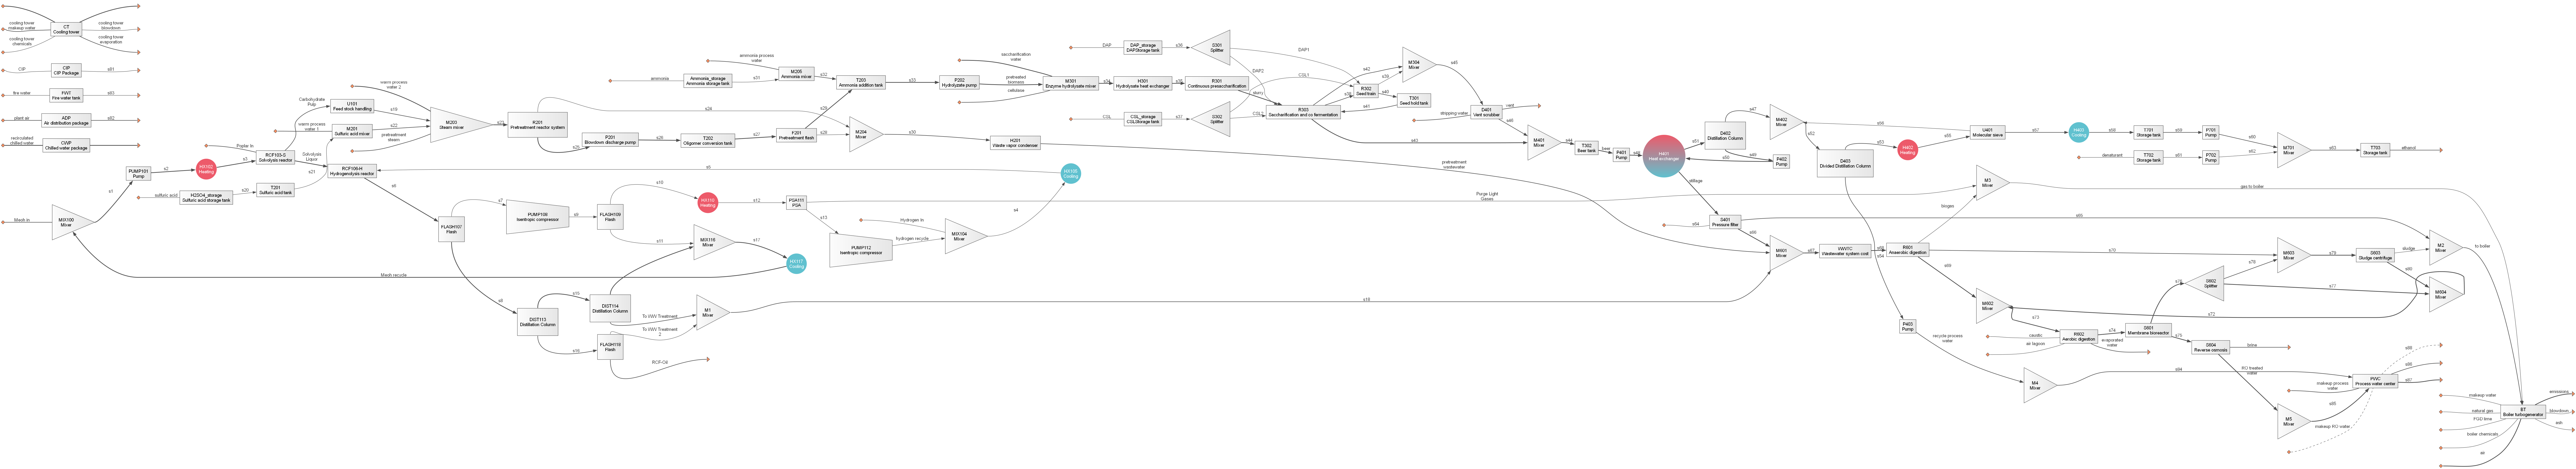

In [ ]:
bst.nbtutorial()
integrated_sys.diagram(format = 'png')

In [63]:
integrated_sys.diagram(format = 'png', file = 'integrated_system_5')

In [ ]:
    operators_per_section = 1  # operators per section from Seider recommendation
    num_process_sections = 3  # number of proces sections from Seider recommendation [2 reactor, 1 separation]
    num_operators_per_shift = operators_per_section * num_process_sections * 1  # multiplied by 2 for large continuous flow process (e.g., 1000 ton/day product). from Seider pg 505
    num_shifts = 5  # number of shifts
    pay_rate = 40  # $/hr
    DWandB = num_operators_per_shift * num_shifts * 2080 * pay_rate  # direct wages and benefits. DWandB [$/year] = (operators/shift)*(5 shifts)*(40 hr/week)*(operating days/year-operator)*($/hr)
    Dsalaries_benefits = 0.15 * DWandB  # direct salaries and benefits from Seider
    O_supplies = 0.06 * DWandB  # Operating supplies and services from Seider
    technical_assistance = 5 * 75000  # $/year. Technical assistance to manufacturing. assume 5 workers at $75000/year
    control_lab = 5 * 80000  # $/year. Control laboratory. assume 5 workers at $80000/year
    labor = DWandB + Dsalaries_benefits + O_supplies + technical_assistance + control_lab 

   

In [64]:
integrated_tea = create_cellulosic_ethanol_tea(integrated_sys)

In [65]:
integrated_tea

CellulosicEthanolTEA: RCF_EtOH
NPV: -1,330,739,267 USD at 10.0% IRR


In [68]:
# Adjusting prices
meoh_frac_in_feed = integrated_sys.feeds[0].imass['Methanol']/integrated_sys.feeds[0].F_mass

In [72]:
integrated_sys.feeds[0].price = meoh_frac_in_feed*0.27455       # 0.33 USD/kg from https://docs.nrel.gov/docs/fy21osti/78547.pdf
integrated_sys.feeds[1].price = 80/907.18/1.2   # [USD/kg] from Bartling paper
integrated_sys.feeds[2].price = 1.606       # [USD/kg] from Bartling paper

In [ ]:
integrated_sys.products[4].price   # Ethanol price USD/kg

0.7198608114634679

In [80]:
print(f'The MSP is {round(integrated_tea.solve_price(integrated_sys.products[0]),4)} USD/kg')

The MSP is 1.1782 USD/kg


In [81]:
rcf_reactor_installed_cost = (solvolysis_reactor.installed_cost +hydrogenolysis_reactor.installed_cost)

In [82]:
print('BioSTEAM system installed equipment cost is', round(integrated_sys.installed_equipment_cost / 1e6, 2), 'MM USD')
print('BioSTEAM system RCF reactor costs only are', round(rcf_reactor_installed_cost / 1e6, 2), 'MM USD')
print('BioSTEAM system purchased equipment cost is', round(integrated_sys.purchase_cost / 1e6, 2), 'MM USD')

BioSTEAM system installed equipment cost is 442.49 MM USD
BioSTEAM system RCF reactor costs only are 221.57 MM USD
BioSTEAM system purchased equipment cost is 228.46 MM USD


In [91]:
print('BioSTEAM system TCI cost is', round(integrated_tea.TCI / 1e6, 2), 'MM USD')

BioSTEAM system TCI cost is 840.96 MM USD


In [ ]:
print('BioSTEAM system variable OPEX is', round((rcf_system.material_cost + rcf_system.utility_cost) / 1e6, 3), 'MM USD/yr')

BioSTEAM system variable OPEX is 182.881 MM USD/yr


In [99]:
import pandas as pd
purchase_df = pd.DataFrame({
    'Unit': [u.ID for u in integrated_sys.cost_units],                          # The system here is named my_sys
    'Installed Cost': [u.installed_cost for u in integrated_sys.cost_units]
})
purchase_df.to_excel('integrated system installed costs.xlsx', index=False)
purchase_df

,Unit,Installed Cost
0,RCF103-S,1.21e+08
1,FWT,1.18e+06
2,PUMP108,0
3,M201,2.2e+03
4,M203,0
...,...,...
57,T702,1.93e+05
58,T201,1.72e+04
59,H301,1.99e+05
60,HX110,7.34e+03


In [106]:
for i, unit in enumerate(integrated_sys.units):
    print(i, unit.ID)

0 MIX100
1 PUMP101
2 HX102
3 RCF103-S
4 MIX104
5 HX105
6 RCF106-H
7 FLASH107
8 PUMP108
9 FLASH109
10 HX110
11 PSA111
12 PUMP112
13 DIST113
14 DIST114
15 MIX116
16 HX117
17 FLASH118
18 M1
19 U101
20 H2SO4_storage
21 T201
22 M201
23 M203
24 R201
25 P201
26 T202
27 F201
28 Ammonia_storage
29 M205
30 T203
31 P202
32 M301
33 H301
34 R301
35 CSL_storage
36 S302
37 DAP_storage
38 S301
39 R303
40 R302
41 T301
42 M304
43 D401
44 M401
45 T302
46 P401
47 H401
48 D402
49 P402
50 S401
51 M204
52 H201
53 M601
54 WWTC
55 R601
56 M602
57 R602
58 S601
59 S602
60 M603
61 S603
62 M604
63 M2
64 S604
65 M5
66 M402
67 D403
68 H402
69 U401
70 H403
71 T701
72 P701
73 T702
74 P702
75 M701
76 T703
77 M3
78 P403
79 M4
80 CWP
81 ADP
82 FWT
83 CIP
84 CT
85 BT
86 PWC


In [108]:
integrated_sys.units[85].results()

Boiler turbogenerator                                      Units        BT
Electricity           Power                                   kW -1.68e+04
                      Cost                                USD/hr -1.32e+03
Medium pressure steam Duty                                 kJ/hr -1.02e+08
                      Flow                               kmol/hr -2.83e+03
                      Cost                                USD/hr      -780
Low pressure steam    Duty                                 kJ/hr -1.87e+08
                      Flow                               kmol/hr -4.84e+03
                      Cost                                USD/hr -1.15e+03
Cooling water         Duty                                 kJ/hr -1.13e+07
                      Flow                               kmol/hr  7.72e+03
                      Cost                                USD/hr      3.77
Fuel (inlet)          Flow                                 kg/hr       465
                      Cost                                USD/hr       101
Ash disposal (outlet) Flow                                 kg/hr  1.46e+03
                      Cost                                USD/hr      46.3
Design                Work                                    kW  1.78e+04
                      Flow rate                            kg/hr  1.69e+05
                      Ash disposal                         kg/hr  1.46e+03
Purchase cost         Baghouse bags                          USD  1.53e+05
                      Boiler                                 USD  2.28e+07
                      Deaerator                              USD  2.45e+05
                      Amine addition pkg                     USD  3.22e+04
                      Hot process water softener system      USD  6.27e+04
                      Turbogenerator                         USD  5.56e+06
Total purchase cost                                          USD  2.88e+07
Utility cost                                              USD/hr  -3.1e+03

In [92]:
*** Break***

SyntaxError: invalid syntax (1675911139.py, line 1)

In [ ]:

import pandas as pd
# Code to estimate the utility cost of equipments

records = []

for unit in rcf_system.units:
    # Utility cost (electricity, steam, etc.)
    utility_cost = getattr(unit, 'utility_cost', 0.0) or 0.0
    
    # Additional OPEX (user-defined; stored as a dictionary)
    #additional_opex_dict = getattr(unit, 'add_OPEX', {})
    #additional_cost = additional_opex_dict.get('Additional OPEX', 0.0) if additional_opex_dict else 0.0

    total_opex = utility_cost 
    
    records.append({
        'Unit ID': unit.ID,
        'Unit Type': type(unit).__name__,
        'Utility Cost [USD/hr]': utility_cost,
        #'Additional OPEX [USD/hr]': additional_cost,
        'Total Operating Cost [USD/hr]': total_opex
    })

df_opex = pd.DataFrame(records).sort_values(by='Total Operating Cost [USD/hr]', ascending=False)

from IPython.display import display
display(df_opex)

,Unit ID,Unit Type,Utility Cost [USD/hr],Total Operating Cost [USD/hr]
13,DIST113,BinaryDistillation,4e+03,4e+03
2,HX102,HXutility,3.16e+03,3.16e+03
16,HX117,HXutility,2.57e+03,2.57e+03
14,DIST114,BinaryDistillation,2.5e+03,2.5e+03
6,RCF106-H,HydrogenolysisReactor,1.81e+03,1.81e+03
9,FLASH109,Flash,123,123
1,PUMP101,Pump,94.1,94.1
7,FLASH107,Flash,82.8,82.8
22,WWTC,WastewaterSystemCost,59.4,59.4
17,FLASH118,Flash,58.1,58.1


Cost breakdown graph

In [ ]:
# Defining different categories

rcf_area = [meoh_h2o_mix, meoh_pump, meoh_heater, solvolysis_reactor, h2_mixer, h2_pre_heat, hydrogenolysis_reactor, h2_pump, cooler_2] 

hydrogen_purification = [R102, pre_psa_pump, pre_psa_flash, pre_psa_heater,psa_system]

methanol_recovery = [crude_distillation, meoh_purifier_col]

# other = [water_remover]

boiler = [BT]

wastewater = [WWT]


In [ ]:
# CAPEX breakdown [USD]

rcf_installed_cost = sum(u.installed_cost for u in rcf_area)
hydrogen_purification_installed_cost = sum(u.installed_cost for u in hydrogen_purification)
methanol_recovery_installed_cost = sum(u.installed_cost for u in methanol_recovery)
boiler_installed_cost = sum(u.installed_cost for u in boiler)
wwt_installed_cost = sum(u.installed_cost for u in wastewater)
# other_installed_cost = sum(u.installed_cost for u in other)


#installed_costs = np.array([cat_upgrading_installed_cost, prod_frac_installed_cost, storage_installed_cost,
#                            0, 0, 0])

In [ ]:
round(rcf_tea.installed_equipment_cost/1e6, 2)

381.9

In [ ]:
# Code for generating Installed Costs breakdown
'''
import matplotlib.pyplot as plt
plt.rc('font',family='Arial')

# Dummy data
values = [rcf_installed_cost, hydrogen_purification_installed_cost, methanol_recovery_installed_cost,boiler_installed_cost,wwt_installed_cost]

# Colors for the slices (change as needed)
colors = ['#88CCEE', '#DDCC77', '#CC6677',  "#19A078","#2F032F"]

fig, ax = plt.subplots(figsize=(5, 5))

# Pie chart with percent labels outside
wedges, texts, autotexts = ax.pie(
    values, 
    colors=colors,
    autopct='%1.1f%%',
    startangle=90,

    wedgeprops=dict(edgecolor='black', linewidth=2),

    pctdistance=1.35,    # move percent labels outside
    textprops={'fontsize': 24}
)



# Optional: remove slice value labels inside the pie
for text in texts:
    text.set_visible(False)

# Title (place above, e.g. for TCI value)
#plt.text(0, 1.45, 'Capital Costs', ha='center', va='center', fontsize=24, fontweight='bold')
#plt.text(0, 1.2, f'TIC: {round(rcf_tea_2.installed_equipment_cost/1e6, 2)} MM$', ha='center', va='center', fontsize=22)

# Remove axes for cleaner look
ax.axis('equal')
plt.tight_layout()
#plt.savefig("rcf_installed_cost_breakdown.png", dpi=500, bbox_inches='tight')
#plt.show()
'''

'\nimport matplotlib.pyplot as plt\nplt.rc(\'font\',family=\'Arial\')\n\n# Dummy data\nvalues = [rcf_installed_cost, hydrogen_purification_installed_cost, methanol_recovery_installed_cost,boiler_installed_cost,wwt_installed_cost]\n\n# Colors for the slices (change as needed)\ncolors = [\'#88CCEE\', \'#DDCC77\', \'#CC6677\',  "#19A078","#2F032F"]\n\nfig, ax = plt.subplots(figsize=(5, 5))\n\n# Pie chart with percent labels outside\nwedges, texts, autotexts = ax.pie(\n    values, \n    colors=colors,\n    autopct=\'%1.1f%%\',\n    startangle=90,\n\n    wedgeprops=dict(edgecolor=\'black\', linewidth=2),\n\n    pctdistance=1.35,    # move percent labels outside\n    textprops={\'fontsize\': 24}\n)\n\n\n\n# Optional: remove slice value labels inside the pie\nfor text in texts:\n    text.set_visible(False)\n\n# Title (place above, e.g. for TCI value)\n#plt.text(0, 1.45, \'Capital Costs\', ha=\'center\', va=\'center\', fontsize=24, fontweight=\'bold\')\n#plt.text(0, 1.2, f\'TIC: {round(rcf_tea

In [ ]:
# Code for generating legend for installed cost breakdown

'''
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rc('font',family='Arial')
# Define categories and corresponding colors from original vertical legend
categories_styled = [
    "RCF reactors",
    "Hydrogen purification",
    "Methanol recovery",
    "Boiler/Turbogenerator",
    "Wastewater treatment"
]

colors_styled = [
'#88CCEE', '#DDCC77', '#CC6677',  "#19A078","#2F032F"
]

patches = [mpatches.Patch(facecolor=color, label=label, edgecolor='black', linewidth=1.2) 
           for color, label in zip(colors_styled, categories_styled)]

fig, ax = plt.subplots(figsize=(10, 2))

# Create legend
legend = ax.legend(
    handles=patches,
    loc='center',
    ncol=1,
    frameon=False,        # No frame around the entire legend
    fontsize=16,
    handlelength=3,
    handletextpad=0.3,
    borderpad=10.8,
    columnspacing=0.8,
    labelspacing=0.3
)

# Ensure no text boxes
for text in legend.get_texts():
    text.set_bbox(None)

ax.axis('off')
#plt.tight_layout()
#plt.savefig("legend_tci.png", dpi=500)
#plt.show()
'''

'\nimport matplotlib.pyplot as plt\nimport matplotlib.patches as mpatches\nplt.rc(\'font\',family=\'Arial\')\n# Define categories and corresponding colors from original vertical legend\ncategories_styled = [\n    "RCF reactors",\n    "Hydrogen purification",\n    "Methanol recovery",\n    "Boiler/Turbogenerator",\n    "Wastewater treatment"\n]\n\ncolors_styled = [\n\'#88CCEE\', \'#DDCC77\', \'#CC6677\',  "#19A078","#2F032F"\n]\n\npatches = [mpatches.Patch(facecolor=color, label=label, edgecolor=\'black\', linewidth=1.2) \n           for color, label in zip(colors_styled, categories_styled)]\n\nfig, ax = plt.subplots(figsize=(10, 2))\n\n# Create legend\nlegend = ax.legend(\n    handles=patches,\n    loc=\'center\',\n    ncol=1,\n    frameon=False,        # No frame around the entire legend\n    fontsize=16,\n    handlelength=3,\n    handletextpad=0.3,\n    borderpad=10.8,\n    columnspacing=0.8,\n    labelspacing=0.3\n)\n\n# Ensure no text boxes\nfor text in legend.get_texts():\n    tex

In [ ]:
#BREAK

NameError: name 'BREAK' is not defined

In [ ]:
#rcf_system.material_cost

173240759.41269717

In [ ]:
chems['Methanol']

Chemical: Methanol (phase_ref='l')
[Names]  CAS: 67-56-1
         InChI: CH4O/c1-2/h2H,1H3
         InChI_key: OKKJLVBELUTLKV-U...
         common_name: methanol
         iupac_name: ('methanol',)
         pubchemid: 887
         smiles: CO
         formula: CH4O
[Groups] Dortmund: <1CH3OH>
         UNIFAC: <1CH3OH>
         PSRK: <1CH3OH>
         NIST: <Empty>
[Data]   MW: 32.042 g/mol
         Tm: 175.15 K
         Tb: 337.63 K
         Tt: 175.61 K
         Tc: 513.38 K
         Pt: 0.18635 Pa
         Pc: 8.2158e+06 Pa
         Vc: 0.00011383 m^3/mol
         Hf: -2.384e+05 J/mol
         S0: 126.8 J/K/mol
         LHV: 6.387e+05 J/mol
         HHV: 7.2672e+05 J/mol
         Hfus: 3215 J/mol
         Sfus: None
         omega: 0.5625
         dipole: 1.7 Debye
         similarity_variable: 0.18726
         iscyclic_aliphatic: 0
         combustion: {'CO2': 1, 'O2'...


In [ ]:
round((chems['Glycerol'].Psat(T = 225+273.15))/1e5,2)

0.15

In [ ]:
#bst.plot_vle_binary_phase_envelope(['Water', 'Isopropylalcohol'], P=101325)


In [ ]:
# HXN = bst.HeatExchangerNetwork('HXN', T_min_app = 10., replace_unit_heat_utilities = True)

In [ ]:
#hx_sys = bst.System('hx_sys', path = (meoh_h2o_mix,meoh_pump, meoh_heater, solvolysis_reactor, h2_mixer, h2_pre_heat, hydrogenolysis_reactor, 
#                                              R102, pre_psa_pump, pre_psa_flash, pre_psa_heater, 
#                                              psa_system, h2_pump ,crude_distillation, meoh_purifier_col, meoh_mixer, cooler_2, 
#                                              water_remover, h2o_mixer, wastewater_mixer), facilities =  [BT, WWT, HXN], recycle = (meoh_recycle, hydrogen_recycle))
#hx_sys.simulate()

In [ ]:
#hx_tea = create_cellulosic_ethanol_tea(hx_sys)

In [ ]:
integrated_tea = create_cellulosic_ethanol_tea(integrated_sys)

In [ ]:
integrated_sys.diagram(format = 'png', file = 'integrated_system_2')

In [ ]:
integrated_sys.products[12].price 

0.7198608114634679

In [ ]:
integrated_sys.units

[<SolvolysisReactor: RCF103-S>,
 <HydrogenolysisReactor: RCF106-H>,
 <Flash: FLASH107>,
 <IsentropicCompressor: PUMP108>,
 <Flash: FLASH109>,
 <HXutility: HX110>,
 <PSA: PSA111>,
 <IsentropicCompressor: PUMP112>,
 <Mixer: MIX104>,
 <HXutility: HX105>,
 <BinaryDistillation: DIST113>,
 <BinaryDistillation: DIST114>,
 <Mixer: MIX116>,
 <HXutility: HX117>,
 <Mixer: MIX100>,
 <Pump: PUMP101>,
 <HXutility: HX102>,
 <Mixer: M1>,
 <FeedStockHandling: U101>,
 <SulfuricAcidStorageTank: H2SO4_storage>,
 <SulfuricAcidTank: T201>,
 <SulfuricAcidMixer: M201>,
 <SteamMixer: M203>,
 <PretreatmentReactorSystem: R201>,
 <BlowdownDischargePump: P201>,
 <OligomerConversionTank: T202>,
 <PretreatmentFlash: F201>,
 <AmmoniaStorageTank: Ammonia_storage>,
 <AmmoniaMixer: M205>,
 <AmmoniaAdditionTank: T203>,
 <HydrolyzatePump: P202>,
 <EnzymeHydrolysateMixer: M301>,
 <HydrolysateHeatExchanger: H301>,
 <ContinuousPresaccharification: R301>,
 <CSLStorageTank: CSL_storage>,
 <MockSplitter: S302>,
 <DAPStorageTank

In [ ]:
for i, unit in enumerate(integrated_sys.units):
    print(i, unit.ID)

0 RCF103-S
1 RCF106-H
2 FLASH107
3 PUMP108
4 FLASH109
5 HX110
6 PSA111
7 PUMP112
8 MIX104
9 HX105
10 DIST113
11 DIST114
12 MIX116
13 HX117
14 MIX100
15 PUMP101
16 HX102
17 M1
18 U101
19 H2SO4_storage
20 T201
21 M201
22 M203
23 R201
24 P201
25 T202
26 F201
27 Ammonia_storage
28 M205
29 T203
30 P202
31 M301
32 H301
33 R301
34 CSL_storage
35 S302
36 DAP_storage
37 S301
38 R303
39 R302
40 T301
41 M304
42 D401
43 M401
44 T302
45 P401
46 H401
47 D402
48 P402
49 S401
50 M204
51 H201
52 M601
53 WWTC
54 R601
55 M602
56 R602
57 S601
58 S602
59 M603
60 S603
61 M604
62 FLASH118
63 M2
64 M601
65 WWTC
66 R601
67 M602
68 R602
69 S601
70 S602
71 M603
72 S603
73 M604
74 M3
75 S604
76 M6
77 M402
78 D403
79 H402
80 U401
81 H403
82 T701
83 P701
84 T702
85 P702
86 M701
87 T703
88 M4
89 P403
90 M5
91 S604
92 CWP
93 FWT
94 ADP
95 CT
96 CIP
97 BT
98 BT
99 PWC


In [ ]:
integrated_sys.show()

System: RCF_EtOH
Highest convergence error among components in recycle
streams {HX117-0, PUMP112-0} after 1 loops:
- flow rate   2.28e-06 kmol/hr (0.018%)
- temperature 2.50e-03 K (0.00081%)
ins...
[0] s18  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] warm_process_water_1  
    phase: 'l', T: 368.15 K, P: 476228 Pa
    flow (kmol/hr): Water  870
[2] pretreatment_steam  
    phase: 'g', T: 541.15 K, P: 1.31722e+06 Pa
    flow (kmol/hr): Water  1.2e+03
[3] warm_process_water_2  
    phase: 'l', T: 368.15 K, P: 476228 Pa
    flow (kmol/hr): Water  5.55e+03
[4] ammonia_process_water  
    phase: 'l', T: 368.15 K, P: 476228 Pa
    flow (kmol/hr): Water  3.31e+03
[5] sulfuric_acid  
    phase: 'l', T: 294.15 K, P: 547155 Pa
    flow (kmol/hr): Water  4.81
                    H2SO4  12.2
[6] cellulase  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water      788
                    Cellulase  31.1
[7] saccharification_water  
    phase: 'l', T: 298.15 K, P: 1013

In [ ]:
# Removing RCF oil from being sent to boiler/turbogenerator
integrated_sys.units[74].disconnect(inlets =integrated_sys.units[74].ins[0])
integrated_sys.units[74].simulate()

In [ ]:
integrated_sys.units[74].ins.remove(integrated_sys.units[74].ins[0])
integrated_sys.units[74].simulate()

In [ ]:
# integrated_sys.simulate()

In [ ]:
integrated_sys.units[74]

Mixer: M3
ins...
[0] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] s80  from  PressureFilter-S401
    phase: 'l', T: 314.66 K, P: 395168 Pa
    flow (kmol/hr): Water              383
                    Ethanol            0.0027
                    Furfural           0.071
                    Glycerol           0.0694
                    LacticAcid         0.635
                    SuccinicAcid       0.123
                    DAP                0.0386
                    AmmoniumSulfate    0.455
                    HMF                0.0331
                    Glucose            0.124
                    Xylose             0.172
                    Arabinose          0.0158
                    Ash                980
                    Lignin             43.6
                    SolubleLignin      0.0873
                    GlucoseOligomer    0.31
                    GalactoseOligomer  0.00321
                    MannoseOligomer    0.00106
                    XyloseOlig

In [ ]:
integrated_sys.units[74]

Mixer: M3
ins...
[0] RCF-Oil  from  Flash-FLASH118
    phase: 'l', T: 400 K, P: 101325 Pa
    flow (kmol/hr): Extract         7.4
                    Glucan          23.8
                    Xylan           5.92
                    Arabinan        0.757
                    Mannan          9.51
                    Galactan        3.6
                    Propylguaiacol  25
                    Propylsyringol  21.2
                    Syringaresinol  4.97
                    G_Dimer         5.73
                    S_Oligomer      3.31
                    G_Oligomer      3.84
[1] s80  from  PressureFilter-S401
    phase: 'l', T: 314.66 K, P: 395168 Pa
    flow (kmol/hr): Water              383
                    Ethanol            0.0027
                    Furfural           0.071
                    Glycerol           0.0694
                    LacticAcid         0.635
                    SuccinicAcid       0.123
                    DAP                0.0386
                    Ammonium

In [ ]:
a1 = bst.Stream('a1', Water=100)
a2 = bst.Stream('a2', Ethanol = 1500)
a3 = bst.Stream('a3', Methanol = 1500)

mixie = bst.units.Mixer(ins = (a1,a2,a3), rigorous = True)
mixie.simulate()


In [ ]:
mixie

Mixer: M7
ins...
[0] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow: 0
[1] a2  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Ethanol  1.5e+03
[2] a2  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Methanol  1.5e+03
outs...
[0] -  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Ethanol   1.5e+03
                    Methanol  1.5e+03


In [ ]:
integrated_sys.units[9]

HXutility: HX105
ins...
[0] s4  from  Mixer-MIX104
    phase: 'g', T: 504.1 K, P: 3e+06 Pa
    flow (kmol/hr): Hydrogen  2.23e+03
outs...
[0] s5  to  HydrogenolysisReactor-RCF106-H
    phases: ('g', 'l'), T: 473.15 K, P: 3e+06 Pa
    flow (kmol/hr): (g) Hydrogen  2.23e+03


In [ ]:
integrated_sys.units[76]

Mixer: M3
ins...
[0] sludge  from  SludgeCentrifuge-S603
    phase: 'l', T: 308.04 K, P: 101325 Pa
    flow (kmol/hr): Water              118
                    Ethanol            2.86e-05
                    Glycerol           0.00135
                    LacticAcid         0.00693
                    SuccinicAcid       0.00241
                    DAP                0.0196
                    AmmoniumSulfate    0.231
                    SO2                0.000279
                    Arabinose          0.000193
                    Ash                15.3
                    NaOH               0.757
                    Lignin             0.677
                    SolubleLignin      0.000953
                    GlucoseOligomer    0.00526
                    GalactoseOligomer  5.45e-05
                    MannoseOligomer    1.8e-05
                    XyloseOligomer     0.00119
                    ArabinoseOligomer  7.64e-06
                    Z_mobilis          0.0416
                 

In [ ]:
BT.ID

'BT'

In [ ]:
integrated_sys.units[97]

BoilerTurbogenerator: BT
ins...
[0] to_boiler  from  Mixer-M3
    phase: 'l', T: 362.89 K, P: 101325 Pa
    flow (kmol/hr): Water              519
                    Ethanol            0.00272
                    Furfural           0.071
                    Glycerol           0.0707
                    LacticAcid         0.642
                    SuccinicAcid       0.126
                    DAP                0.0582
                    AmmoniumSulfate    0.686
                    HMF                0.0331
                    SO2                0.000279
                    Glucose            0.124
                    Xylose             0.172
                    Arabinose          0.016
                    Extract            7.4
                    Acetate            1.19
                    Ash                995
                    NaOH               0.853
                    Lignin             44.3
                    SolubleLignin      0.0882
                    GlucoseOligomer    0

In [ ]:
# Time to make sure there is only one BT
bst.facilities.BoilerTurbogenerator

In [ ]:
print(f'The MSP with complete system is {round(integrated_tea.solve_price(integrated_sys.products[0]),4)} USD/kg')

The MSP with complete system is 1.1715 USD/kg


In [ ]:
integrated_sys.units[80]

BinaryDistillation: D403
ins...
[0] s67  from  Mixer-M402
    phase: 'g', T: 386.4 K, P: 162120 Pa
    flow (kmol/hr): Water    1.3e+03
                    Ethanol  545
                    NH3      0.751
outs...
[0] s68  to  HXutility-H402
    phase: 'g', T: 363.92 K, P: 162120 Pa
    flow (kmol/hr): Water    130
                    Ethanol  545
                    NH3      0.751
[1] s69  to  Pump-P403
    phase: 'l', T: 386.85 K, P: 162120 Pa
    flow (kmol/hr): Water    1.17e+03
                    Ethanol  0.00456


In [ ]:
cellulosic

In [ ]:
purchase_df

,Unit,Purchase Cost
0,HX102,1.76e+05
1,HX115,2.28e+06
2,HX117,1.4e+05
3,FLASH107,5.9e+05
4,HX110,5.04e+03
5,PSA111,1.23e+06
6,DIST114,6.87e+06
7,PUMP108,0
8,PUMP112,2.7e+06
9,FLASH109,4.99e+04


In [ ]:
meoh_pump.results()

Pump                              Units      PUMP101
Electricity         Power            kW     1.56e+03
                    Cost         USD/hr          122
Design              Type                 Centrifugal
                    Ideal power      hp     1.65e+03
                    Flow rate       gpm      3.3e+03
                    Efficiency                 0.789
                    Power            hp     2.09e+03
                    Head             ft      3.1e+03
                    Motor size       hp          500
Purchase cost       Pump            USD     4.86e+05
                    Motor (x5)      USD     2.61e+05
Total purchase cost                 USD     7.47e+05
Utility cost                     USD/hr          122

In [ ]:
meoh_pump.power_utility

PowerUtility:
consumption: 1.56e+03 kW
production: 0 kW
power: 1.56e+03 kW
cost: 122 USD/hr


In [ ]:
import pandas as pd
for u in rcf_system.units:
    if hasattr(u, 'power_utility'):
        print(f"{u.ID} electricity: {u.power_utility.rate:.2f} kW")

    if hasattr(u, 'heat_utilities'):
        for h in u.heat_utilities:
            print(f"{u.ID} {h.duty/1e6:.2f} MJ/hr")


utility_df_2 = pd.DataFrame({
    'Unit': [u.ID for u in rcf_system.cost_units if hasattr(u, 'power_utility')],                          # The system here is named my_sys
    'Heat Utilities': [u.heat_utilities for u in rcf_system.cost_units if hasattr(u, 'heat_utilities')],
    'Power utilities': [u.power_utility.rate for u in rcf_system.cost_units if hasattr(u, 'power_utility')]
})            

MIX100 electricity: 0.00 kW
PUMP101 electricity: 1202.72 kW
HX102 electricity: 0.00 kW
HX102 320.99 MJ/hr
RCF103-S electricity: 28.16 kW
MIX104 electricity: 0.00 kW
HX105 electricity: 0.00 kW
HX105 -2.02 MJ/hr
RCF106-H electricity: 0.00 kW
RCF106-H 23.01 MJ/hr
RCF106-H 23.01 MJ/hr
RCF106-H 23.01 MJ/hr
RCF106-H 23.01 MJ/hr
RCF106-H 23.01 MJ/hr
RCF106-H 23.01 MJ/hr
RCF106-H 23.01 MJ/hr
RCF106-H 23.01 MJ/hr
FLASH107 electricity: 0.00 kW
FLASH107 -248.53 MJ/hr
PUMP108 electricity: 0.00 kW
FLASH109 electricity: 0.00 kW
FLASH109 -9.30 MJ/hr
HX110 electricity: 0.00 kW
HX110 2.28 MJ/hr
PSA111 electricity: 718.22 kW
PUMP112 electricity: 0.00 kW
PUMP112 0.01 MJ/hr
DIST113 electricity: 19.30 kW
DIST113 -12.10 MJ/hr
DIST113 649.09 MJ/hr
DIST114 electricity: 8.95 kW
DIST114 -411.00 MJ/hr
DIST114 383.51 MJ/hr
MIX116 electricity: 0.00 kW
HX117 electricity: 0.00 kW
HX117 -513.24 MJ/hr
FLASH118 electricity: 0.00 kW
FLASH118 9.44 MJ/hr
M1 electricity: 0.00 kW
M2 electricity: 0.00 kW
BT electricity: -781

In [ ]:
utility_df_2.to_excel('utility_df.xlsx')

BioSTEAM system installed equipment cost is 368.53 MM USD
BioSTEAM system variable OPEX is 286.261 MM USD/yr


In [ ]:
print(f'Bartling et al system installed system cost is {round(((290362170+33147597)/1e6),2)} MM USD')
print(f'Variable OPEX is 156.7 MM USD/yr')

Bartling et al system installed system cost is 323.51 MM USD
Variable OPEX is 156.7 MM USD/yr


In [ ]:
rcf_system.products[0]

Stream: RCF-Oil from <Flash: FLASH118>
phase: 'l', T: 400 K, P: 101325 Pa
flow (kmol/hr): Extract         7.4
                Glucan          23.8
                Xylan           5.92
                Propylguaiacol  25
                Propylsyringol  21.2
                Syringaresinol  4.97
                G_Dimer         5.73
                S_Oligomer      3.31
                G_Oligomer      3.84


In [ ]:
print(f'Crude RCF Oil production is {round((rcf_system.products[0].F_mass*24*330)/1e6,2)} MM kg/yr') 
print(f'In Bartling et al, it is 185.9 MM kg/yr')
print(f'Difference is probably because they also consider loss of Arabinan Galactan and Mannan which I do not')
print(f'But our amounts of carbohydrate extractives were similar so this is probably not it')

Crude RCF Oil production is 196.67 MM kg/yr
In Bartling et al, it is 185.9 MM kg/yr
Difference is probably because they also consider loss of Arabinan Galactan and Mannan which I do not
But our amounts of carbohydrate extractives were similar so this is probably not it


In [ ]:
monomers_kg_hr = rcf_system.products[0].imass['Propylguaiacol'] + rcf_system.products[0].imass['Propylsyringol']

In [ ]:
print(f'The monomer yield obtained here is {round((monomers_kg_hr/(2000/24)),2)} kg/dry metric ton biomass') 
print(f'In Bartling et al, this is 88.4 kg/dry metric ton biomass')
print('Difference might be due to recovery of RCF Oil, in my case its a 100% recovery\nIn Bartling et al., it is 91.8%')
# Seems that yields are better, so RCF price should technically be lower...

The monomer yield obtained here is 99.75 kg/dry metric ton biomass
In Bartling et al, this is 88.4 kg/dry metric ton biomass
Difference might be due to recovery of RCF Oil, in my case its a 100% recovery
In Bartling et al., it is 91.8%


In [ ]:
solvolysis_reactor-0

MultiStream: Conc. Pulp from <SolvolysisReactor: RCF103-S> to <Mixer: M1>
phases: ('l', 's'), T: 298.15 K, P: 101325 Pa
flow (kmol/hr): (l) Water     925
                    Sucrose   0.243
                    Ash       1e+03
                    Lignin    46.8
                    Glucan    215
                    Xylan     78.6
                    Arabinan  1.26
                    ...       26.2


In [ ]:
rcf_reactor_purchase_cost = solvolysis_reactor.purchase_cost +hydrogenolysis_reactor.purchase_cost
rcf_reactor_installed_cost = rcf_reactor_purchase_cost*my_tea.lang_factor
print(f'RCF Reactor only Installed Costs are {round((rcf_reactor_installed_cost/1e6),2)} MM USD')
print(f'In Bartling et al, these are {round((290362170/1e6),2)} MM USD')
print('Simply lovely')

NameError: name 'my_tea' is not defined

In [ ]:
# Since reactor costs are not that different, it could be that the operating expenses are
# causing the difference between MSPs

In [ ]:
import pandas as pd
from IPython.display import display

records = []

for unit in rcf_system.units:    # system name is my_sys here
    heat_utilities = getattr(unit, 'heat_utilities', [])  # Default to empty list if not present
    total_duty = sum(h.duty for h in heat_utilities if h.duty != 0)  # Can also use h.duty > 0 for heating only

    records.append({
        'Unit ID': unit.ID,
        'Unit Type': type(unit).__name__,
        'Utility [kJ/hr]': total_duty
    })

df_opex = pd.DataFrame(records)

# Remove zero-utility rows (optional)
df_opex = df_opex[df_opex['Utility [kJ/hr]'] != 0]

# Sort in descending order of heat duty
df_opex = df_opex.sort_values(by='Utility [kJ/hr]', ascending=False).reset_index(drop=True)

total_heat = df_opex['Utility [kJ/hr]'].sum()
df_opex['% of Total'] = df_opex['Utility [kJ/hr]'] / total_heat 
#df_opex.to_excel('heat_utilities_summary.xlsx', index=False)

display(df_opex)

,Unit ID,Unit Type,Utility [kJ/hr],% of Total
0,DIST113,BinaryDistillation,6.37e+08,-0.529
1,HX102,HXutility,3.21e+08,-0.267
2,RCF106-H,HydrogenolysisReactor,1.84e+08,-0.153
3,FLASH118,Flash,9.44e+06,-0.00785
4,HX110,HXutility,2.28e+06,-0.0019
5,PUMP112,IsentropicCompressor,5.98e+03,-4.97e-06
6,HX105,HXutility,-2.02e+06,0.00168
7,FLASH109,Flash,-9.3e+06,0.00773
8,DIST114,BinaryDistillation,-2.75e+07,0.0228
9,FLASH107,Flash,-2.49e+08,0.207


In [ ]:
total_heating = df_opex[df_opex['Utility [kJ/hr]'] > 0]['Utility [kJ/hr]'].sum()
total_cooling= -df_opex[df_opex['Utility [kJ/hr]'] < 0]['Utility [kJ/hr]'].sum()

In [ ]:
print(f'Total RCF heat demand is {round((total_heating/1e3/3600),2)} MJ/s')
print('For Bartling et al, this value is 295.2 MJ/s')
# So heat demand is way higher

Total RCF heat demand is 320.5 MJ/s
For Bartling et al, this value is 295.2 MJ/s


In [ ]:
bst.settings.get_agent('natural_gas').regeneration_price /(16)

0.218545

In [ ]:
total_heating*(bst.settings.get_agent('natural_gas').regeneration_price /(16))

252155911.27497792

In [ ]:
# rcf_system()

NameError: name 'name' is not defined

In [ ]:
print(f'Total RCF cooling demand is {round((total_cooling/1e3/3600),2)} MJ/s')

Total RCF cooling demand is 654.9 MJ/s


In [ ]:
bst.settings.get_heating_agent('high_pressure_steam')

UtilityAgent: high_pressure_steam
heat_transfer_efficiency: 0.850
heat_transfer_price: 0 USD/kJ
regeneration_price: 0.317 USD/kmol
T_limit: None
phase: 'g'
T: 508.99 K
P: 3.11e+06 Pa
flow (kmol/hr): Water  1


In [ ]:
# So from the prices it seems as if natural gas is way more expensive than HP stem
# Lets see if my system is using natural gas

In [ ]:

def find_units_using_agent(agent_ID, system=None):
    agent = bst.settings.get_agent(agent_ID)
    if not agent:
        print(f"No agent found with ID '{agent_ID}'")
        return []

    if system is None:
        system = rcf_system

    units_using_agent = []

    for unit in system.units:
        if hasattr(unit, 'heat_utilities'):
            for hu in unit.heat_utilities:
                if hu.agent is agent:
                    units_using_agent.append((unit.ID, hu.duty, hu.agent.ID))

    return units_using_agent

# Example usage
results = find_units_using_agent('natural_gas')

# Display results
if results:
    print(f"\nUnits using agent 'ethylene':")
    for ID, duty, agent_ID in results:
        print(f" - Unit {ID} | Duty: {duty:.2f} kJ  | Agent: {agent_ID}")
else:
    print("No units are using this agent.")

No units are using this agent.


In [ ]:
# Wierdly enough, none of the unit ops are using natural gas indicating that evne if my system has
# higher utility requirements, they are being met off by much cheaper utilities

In [ ]:
80/1.2

66.66666666666667

In [ ]:
print(f'The MSP is {round(my_tea.solve_price(rcf_oil),4)} USD/kg')

The MSP is 1.8568 USD/kg


In [ ]:
rcf_system.feeds[0]

Stream: Meoh_in to <Mixer: MIX100>
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (kmol/hr): Water     2.26e+03
                Methanol  73.7


In [ ]:
feedstock_cost = rcf_system.feeds[1].price * rcf_system.feeds[1].F_mass * 24 * 330 
print(f'Feedstock cost is {round((feedstock_cost/1e6),2)} MM USD/year')
print(f'Bartling et al., it is 57.9 MM USD/yr')


Feedstock cost is 58.2 MM USD/year
Bartling et al., it is 57.9 MM USD/yr


In [ ]:
solvent_makeup_cost = rcf_system.feeds[0].F_mass*24*330*rcf_system.feeds[0].price
print(f'Solvent make up cost is {round((solvent_makeup_cost/1e6),2)} MM USD/year')
print(f'In Bartling et al., this cost is 12.1 MM USD/yr')


Solvent make up cost is 5.13 MM USD/year
In Bartling et al., this cost is 12.1 MM USD/yr


In [ ]:
rcf_system.utility_cost

98177657.74360067

In [ ]:
rcf_system.products[4].show(flow = 'kg/hr')

Stream: RCF-Oil from <Flash: FLASH118>
phase: 'l', T: 400 K, P: 101325 Pa
flow (kg/hr): Extract         1.33e+03
              Cellulose       3.87e+03
              Xylan           782
              Propylguaiacol  4.16e+03
              Propylsyringol  4.16e+03
              Syringaresinol  2.08e+03
              G_Dimer         2.08e+03
              S_Oligomer      2.08e+03
              G_Oligomer      2.08e+03


In [ ]:
carbohydrate_content = (1.33e03+3.87e03)
carbohydrate_content/rcf_system.products[4].F_mass

0.23002064287820703

In [ ]:
# I just manually reduced the solvent price, and I found that basically when its the same 
# solvent recovery price as suggested by Bartling et al, the MJSP kind of drops by 50 cents,
# and is 1.51 USD/kg. I also realized that the OPEX goes down by 80 MM USD/yr

In [ ]:
# Even at that point, there is a 46 MM USD/yr difference in OPEX. Sizable chunk probably because of fixed OPEX also in operatinng expenditures in biosteam

In [ ]:
hydrogen_cost = rcf_system.feeds[2].price*rcf_system.feeds[2].F_mass*24*330
print(f'Hydrogen cost is {round((hydrogen_cost/1e6),2)} MM USD/year')
print(f'In Bartling et al., this cost is just 5.5 MM USD/yr')


Hydrogen cost is 21.01 MM USD/year
In Bartling et al., this cost is just 5.5 MM USD/yr


In [ ]:
rcf_system.ins[0].F_mass*24

2400000.0

In [ ]:
my_tea.NPV

-3079927935.3527136

In [ ]:

rcf_system.products[4].F_mass/(2000/24)

271.28

In [ ]:
(meoh_h2o_mix.outs[0].F_vol*1000)/(2e6/24)

9.000189090970158

In [ ]:
rcf_system

System: RCF_System
Highest convergence error among components in recycle
streams {HX117-0, PUMP112-0} after 1 loops:
- flow rate   1.26e-03 kmol/hr (0.54%)
- temperature 1.14e-13 K (1.9e-14%)
ins...
[0] Poplar_In  
    phases: ('l', 's'), T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): (l) Water      925
                    (s) Sucrose    0.243
                        Extract    7.4
                        Acetate    48.6
                        Ash        1e+03
                        Lignin     156
                        Cellulose  238
                        Xylan      84.5
                        Arabinan   1.26
                        Mannan     19
                        Galactan   7.2
[1] Meoh_in  
    phase: 'l', T: 298.15 K, P: 101325 Pa
    flow (kmol/hr): Water     2.33e+03
                    Methanol  97.4
[2] Hydrogen_In  
    phase: 'g', T: 353.15 K, P: 3e+06 Pa
    flow (kmol/hr): Hydrogen  819
outs...
[0] Carbohydrate_Pulp  
    phases: ('l', 's'), T: 298.15 K, P: 10132

In [ ]:
trial_str = bst.MultiStream()
trial_str.copy_like(poplar_in)

In [ ]:
trial_str.show(flow = 'kg/hr', composition = True)

MultiStream: s31
phases: ('g', 'l', 's'), T: 298.15 K, P: 101325 Pa
composition (%): (g) Water      100
                     ---------  1.67e+04 kg/hr
                 (l) Sucrose    0.1
                     Extract    1.6
                     Acetate    3.5
                     Ash        1.2
                     Lignin     28.5
                     Cellulose  46.4
                     Xylan      13.4
                     Arabinan   0.2
                     Mannan     3.7
                     Galactan   1.4
                     ---------  8.33e+04 kg/hr


In [ ]:
rcf_system.outs[0].show(flow = 'kg/hr', composition = True)

MultiStream: Carbohydrate_Pulp from <SolvolysisReactor: RCF103-S>
phases: ('l', 's'), T: 298.15 K, P: 101325 Pa
composition (%): (l) Water      100
                     ---------  1.67e+04 kg/hr
                 (s) Sucrose    0.144
                     Ash        1.73
                     Lignin     12.3
                     Cellulose  60.2
                     Xylan      18
                     Arabinan   0.288
                     Mannan     5.33
                     Galactan   2.02
                     ---------  5.78e+04 kg/hr


In [ ]:
poplar_try = bst.MultiStream('Poplar_Try', 
                 l=[('Water', biomass_moisture*biomass_flow*1e3),('Poplar', biomass_flow*1e3)], 
                 phases = ('s','l'), units='kg/d')



In [ ]:
poplar_try.show(composition = True, flow = 'kg/hr')

MultiStream: Poplar_Try
phases: ('l', 's'), T: 298.15 K, P: 101325 Pa
composition (%): (l) Water      16.7
                     Sucrose    0.0833
                     Extract    1.33
                     Acetate    2.92
                     Ash        1
                     Lignin     23.8
                     Cellulose  38.7
                     Xylan      11.2
                     Arabinan   0.167
                     Mannan     3.08
                     Galactan   1.17
                     ---------  1e+05 kg/hr


In [ ]:
poplar_try.F_mass

100000.0

In [ ]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
HXN = bst.HeatExchangerNetwork('HXN', T_min_app = 5.)


In [ ]:
hx_sys = bst.System.from_units('hx_sys', units = [meoh_h2o_mix, meoh_pump, meoh_heater, solvolysis_reactor, h2_mixer, h2_pre_heat, hydrogenolysis_reactor, 
                                              R102, pre_psa_pump, pre_psa_flash, pre_psa_heater,
                                              psa_system, h2_pump ,crude_distillation, meoh_purifier_col, meoh_mixer, cooler_2, 
                                              water_remover, HXN], facility_recycle= (meoh_recycle, hydrogen_recycle))

In [ ]:
hx_sys.simulate()

C:\Users\hwadg\AppData\Local\Temp\ipykernel_50152\4224563399.py:264: CostWarning: <SolvolysisReactor: RCF103-S> Vertical vessel weight (5.238e+06 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_50152\4224563399.py:264: CostWarning: <SolvolysisReactor: RCF103-S> Vertical vessel length (59.06 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_50152\1646559446.py:167: CostWarning: <HydrogenolysisReactor: RCF106-H> Vertical vessel weight (2.338e+06 lb) is out of bounds (4200 to 1e+06 lb) for cost correlation
  self._vertical_vessel_design(
C:\Users\hwadg\AppData\Local\Temp\ipykernel_50152\1646559446.py:167: CostWarning: <HydrogenolysisReactor: RCF106-H> Vertical vessel length (64.58 ft) is out of bounds (12 to 40 ft) for cost correlation
  self._vertical_vessel_design(
c:\Users\hwadg\anaconda3\envs\pyfuel\lib\site-packages

In [ ]:
round(HXN.actual_heat_util_load/HXN.original_heat_util_load, 2)


0.77

In [ ]:
hx_tea = ConventionalEthanolTEA(system = hx_sys,
                                IRR = 0.10,
                                duration = (2016, 2046),
                                depreciation = 'MACRS7',
                                income_tax = 0.21,
                                operating_days = 330,
                                lang_factor = 4.28,
                                construction_schedule = (0.08, 0.60, 0.32),
                                WC_over_FCI = 0.05,
                                labor_cost =0,
                                #fringe_benefits = 0,
                                property_tax= 0, #0.001, 
                                property_insurance=0, # 0.005, 
                                #supplies=0, 
                                maintenance=0, #0.01, 
                                administration=0 #0.005
                                )

In [ ]:
hx_sys.feeds[0].price = 80/907.18
hx_sys.feeds[1].price = 1.606  
hx_sys.feeds[2].price = 0.27455

In [ ]:
hx_sys.diagram(format = 'png',file = 'hx_sys')

In [ ]:
hx_sys.feeds[2]

Stream: Meoh_in to <Mixer: MIX100>
phase: 'l', T: 298.15 K, P: 101325 Pa
flow (kmol/hr): Water     2.33e+03
                Methanol  97.4


In [ ]:
hx_sys.operating_hours = 330 * 24


print('Heat integrated system installed equipment cost is', round(hx_sys.installed_equipment_cost / 1e6, 2), 'MM USD')
print('Heat integrated system OPEX is', round((hx_sys.material_cost + hx_sys.utility_cost) / 1e6, 3), 'MM USD/yr')

Heat integrated system installed equipment cost is 372.81 MM USD
Heat integrated system OPEX is 266.577 MM USD/yr


In [ ]:
hx_tea.NPV

-2900098197.700111

In [ ]:
hx_sys.outs[3]

Stream: RCF-Oil from <Flash: FLASH118>
phase: 'l', T: 400 K, P: 101325 Pa
flow (kmol/hr): Extract         7.4
                Cellulose       23.8
                Xylan           5.92
                Propylguaiacol  25
                Propylsyringol  21.2
                Syringaresinol  4.97
                G_Dimer         5.73
                S_Oligomer      3.31
                G_Oligomer      3.84


In [ ]:
print(f'The MSP is {round(hx_tea.solve_price(hx_sys.outs[3]),4)} USD/kg')

The MSP is 1.7491 USD/kg


In [ ]:
for u in hx_sys.units:
    if hasattr(u, 'power_utility'):
        print(f"{u.ID} electricity: {u.power_utility.rate:.2f} kW")

    if hasattr(u, 'heat_utilities'):
        for h in u.heat_utilities:
            print(f"{u.ID} {h.duty/1e6:.2f} MJ/hr")

DIST114 electricity: 10.32 kW
DIST114 -483.44 MJ/hr
DIST114 465.25 MJ/hr
HX115 electricity: 0.00 kW
HX115 -662.19 MJ/hr
RCF103-S electricity: 36.85 kW
RCF106-H electricity: 0.00 kW
RCF106-H 19.52 MJ/hr
FLASH107 electricity: 0.00 kW
FLASH107 -323.16 MJ/hr
PUMP108 electricity: -0.00 kW
FLASH109 electricity: 0.00 kW
FLASH109 -9.60 MJ/hr
HX110 electricity: 0.00 kW
HX110 2.32 MJ/hr
PSA111 electricity: 779.81 kW
PUMP112 electricity: 0.00 kW
PUMP112 0.01 MJ/hr
MIX104 electricity: 0.00 kW
HX105 electricity: 0.00 kW
HX105 -2.02 MJ/hr
MIX116 electricity: 0.00 kW
HX117 electricity: 0.00 kW
HX117 -53.35 MJ/hr
MIX100 electricity: 0.00 kW
PUMP101 electricity: 1558.17 kW
HX102 electricity: 0.00 kW
HX102 444.34 MJ/hr
DIST113 electricity: 25.18 kW
DIST113 -713.95 MJ/hr
DIST113 1032.14 MJ/hr
FLASH118 electricity: 0.00 kW
FLASH118 10.31 MJ/hr
HXN electricity: 0.00 kW
HXN -477.88 MJ/hr
HXN -400.55 MJ/hr
HXN 800.59 MJ/hr
HXN -0.00 MJ/hr
HXN 0.00 MJ/hr


In [ ]:
hx_sys.units

[<BinaryDistillation: DIST114>,
 <HXutility: HX115>,
 <SolvolysisReactor: RCF103-S>,
 <HydrogenolysisReactor: RCF106-H>,
 <Flash: FLASH107>,
 <IsentropicCompressor: PUMP108>,
 <Flash: FLASH109>,
 <HXutility: HX110>,
 <PSA: PSA111>,
 <IsentropicCompressor: PUMP112>,
 <Mixer: MIX104>,
 <HXutility: HX105>,
 <Mixer: MIX116>,
 <HXutility: HX117>,
 <Mixer: MIX100>,
 <Pump: PUMP101>,
 <HXutility: HX102>,
 <BinaryDistillation: DIST113>,
 <Flash: FLASH118>,
 <HeatExchangerNetwork: HXN>]

In [ ]:
hx_sys.units[0].results()

Distillation Column                                        Units   DIST114
Electricity         Power                                     kW      10.3
                    Cost                                  USD/hr     0.807
Cooling water       Duty                                   kJ/hr -4.83e+08
                    Flow                                 kmol/hr   3.3e+05
                    Cost                                  USD/hr       161
Low pressure steam  Duty                                   kJ/hr  4.65e+08
                    Flow                                 kmol/hr   1.2e+04
                    Cost                                  USD/hr  2.86e+03
Design              Theoretical feed stage                               2
                    Theoretical stages                                   8
                    Minimum reflux                         Ratio      0.36
                    Reflux                                 Ratio      0.72
                    Actual stages                                       14
                    Height                                    ft      31.7
                    Diameter                                  ft      42.1
                    Wall thickness                            in       1.5
                    Weight                                    lb  5.32e+05
Purchase cost       Trays                                    USD  3.94e+06
                    Tower                                    USD  9.41e+05
                    Platform and ladders                     USD  5.56e+04
                    Condenser - Floating head                USD  1.17e+06
                    Reflux drum - Vertical pressure ...      USD  3.77e+05
                    Reflux drum - Platform and ladders       USD  4.25e+04
                    Pump - Pump                              USD  9.84e+03
                    Pump - Motor                             USD       707
                    Reboiler - Floating head                 USD  3.34e+05
Total purchase cost                                          USD  6.87e+06
Utility cost                                              USD/hr  3.02e+03

In [ ]:
hx_sys.operating_hours = 330 * 24

print('Heat integrated system installed equipment cost is', round(hx_sys.installed_equipment_cost / 1e6, 2), 'MM USD')
print('Heat integrated system OPEX is', round((hx_sys.material_cost + hx_sys.utility_cost) / 1e6, 3), 'MM USD/yr')

Heat integrated system installed equipment cost is 370.08 MM USD
Heat integrated system OPEX is 266.578 MM USD/yr


In [ ]:
rcf_system.purchase_cost

85467128.42715235

In [ ]:
hx_sys.purchase_cost

86468050.83293647

In [ ]:
heat_integrated_purchase_df = pd.DataFrame({
    'Unit': [u.ID for u in hx_sys.cost_units],                          # The system here is named my_sys
    'Purchase Cost': [u.purchase_cost for u in hx_sys.cost_units]
})
# purchase_df.to_excel('equipment_purchase_costs.xlsx', index=False)
heat_integrated_purchase_df

,Unit,Purchase Cost
0,HXN,1e+06
1,HX117,1.4e+05
2,FLASH109,4.99e+04
3,RCF103-S,6.3e+07
4,DIST113,2.42e+06
5,HX115,2.28e+06
6,HX105,5.18e+03
7,FLASH107,5.89e+05
8,PUMP112,2.7e+06
9,HX102,1.76e+05


In [ ]:
purchase_df

,Unit,Purchase Cost
0,HX117,1.4e+05
1,FLASH109,4.99e+04
2,RCF103-S,6.3e+07
3,DIST113,2.42e+06
4,HX115,2.28e+06
5,HX102,1.76e+05
6,HX105,5.18e+03
7,FLASH107,5.89e+05
8,PUMP112,2.7e+06
9,FLASH118,4.82e+04


In [ ]:
print('Heat integrated system OPEX is', round((hx_sys.material_cost + hx_sys.utility_cost) / 1e6, 3), 'MM USD/yr')

Heat integrated system OPEX is 1926.976 MM USD/yr


In [ ]:
# Add RCF catalyst cost separately as OPEX 

In [ ]:

def find_units_using_agent(agent_ID, system=None):
    agent = bst.settings.get_agent(agent_ID)
    if not agent:
        print(f"No agent found with ID '{agent_ID}'")
        return []

    if system is None:
        system = rcf_system    # Assynes systems name is my_sys

    units_using_agent = []

    for unit in system.units:
        if hasattr(unit, 'heat_utilities'):
            for hu in unit.heat_utilities:
                if hu.agent is agent:
                    units_using_agent.append((unit.ID, hu.duty, hu.agent.ID))

    return units_using_agent

# Example usage
results = find_units_using_agent('medium_pressure_steam')

# Display results
if results:
    print(f"\nUnits using agent 'ethylene':")
    for ID, duty, agent_ID in results:
        print(f" - Unit {ID} | Duty: {duty:.2f} kJ  | Agent: {agent_ID}")
else:
    print("No units are using this agent.")

No units are using this agent.


In [ ]:
import pandas as pd
from IPython.display import display

records = []

for unit in hx_sys.units:    # system name is my_sys here
    heat_utilities = getattr(unit, 'heat_utilities', [])  # Default to empty list if not present
    total_duty = sum(h.duty for h in heat_utilities if h.duty != 0)  # Can also use h.duty > 0 for heating only

    records.append({
        'Unit ID': unit.ID,
        'Unit Type': type(unit).__name__,
        'Utility [kJ/hr]': total_duty
    })

hx_df_opex = pd.DataFrame(records)

# Remove zero-utility rows (optional)
hx_df_opex = hx_df_opex[hx_df_opex['Utility [kJ/hr]'] != 0]

# Sort in descending order of heat duty
hx_df_opex = hx_df_opex.sort_values(by='Utility [kJ/hr]', ascending=False).reset_index(drop=True)

total_heat_hx = hx_df_opex['Utility [kJ/hr]'].sum()
hx_df_opex['% of Total'] = hx_df_opex['Utility [kJ/hr]'] / total_heat_hx
hx_df_opex.to_excel('heat_utilities_summary.xlsx', index=False)

display(hx_df_opex)

,Unit ID,Unit Type,Utility [kJ/hr],% of Total
0,DIST113,BinaryDistillation,8.29e+08,4.57
1,HX102,HXutility,4.44e+08,2.45
2,RCF106-H,HydrogenolysisReactor,1.95e+07,0.108
3,FLASH118,Flash,1.03e+07,0.0568
4,HX110,HXutility,2.32e+06,0.0128
5,PUMP112,IsentropicCompressor,5.98e+03,3.3e-05
6,HX105,HXutility,-2.02e+06,-0.0111
7,FLASH109,Flash,-9.6e+06,-0.053
8,DIST114,BinaryDistillation,-1.82e+07,-0.1
9,HX117,HXutility,-5.33e+07,-0.294


In [ ]:
total_heating_hx = hx_df_opex[hx_df_opex['Utility [kJ/hr]'] > 0]['Utility [kJ/hr]'].sum()
# total_cooling_hx= -hx_df_opex[df_opex['Utility [kJ/hr]'] < 0]['Utility [kJ/hr]'].sum()

In [ ]:
print(f'Total RCF heat demand is {round((total_heating_hx/1e3/3600),2)} MJ/s')
print('For Bartling et al, this value is 295.2 MJ/s')

Total RCF heat demand is 362.72 MJ/s
For Bartling et al, this value is 295.2 MJ/s


In [ ]:
bst.settings.get_agent('high_pressure_steam').LHV

-44011.496

In [ ]:
bst.settings.get_agent('natural_gas').LHV

802567.008

In [ ]:
bst.facilities.BoilerTurbogenerator